# Data Collection

The original dataset, US Domestic Flights Delay Prediction (2013 - 2018) (Source: [Kaggle](https://www.kaggle.com/datasets/gabrielluizone/us-domestic-flights-delay-prediction-2013-2018)), is provided as a zip archive of 1.54 GB. When decompressed, the archive contains 60 files with a total size of 13.6 GB. Each file corresponds to one month of data, starting from January 2014 and ending in December 2018.

Steps for collecting and cleaning the data:

*	Loading the first file
*	Evaluating the data’s size and quality
*	Defining the specific data needed for the project
*	Developing a process for data organization and cleaning
*	Testing the code on one month’s data file
*	Applying the code to all files
*	Accumulating the complete dataset
*   Testing the accuracy of the data, rectifying and cleaning the data


The archive file (csv_flight.zip) was downloaded and saved locally.

## Modules Initialisation and Functions Defenition

In [1]:
import zipfile
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from dateutil import tz
from time import time
import pickle
import scipy.stats as st

os.chdir('/Users/a.kholodov/Documents/02. Personal/20. Education/50. Universities/Springboard/Springboard_git/Springboard _repo/CS2-flights-delay-REPO')

# pd.set_option('display.max_rows', 130)
# pd.set_option('display.width', 200)

# Loading timezones for IATA codes of airports
IATAtz_df = pd.read_csv('https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap', 
                        sep = '\t', 
                        index_col=0, 
                        header=None)

# Dictionary with IATA codes as keys and timezones as values
IATAtz = IATAtz_df.to_dict('dict')[1]
del(IATAtz_df)

# List of dates of start/end of DST
DST = pd.to_datetime(['2014-03-09', '2014-11-02', '2015-03-08', '2015-11-01', 
       '2016-03-13', '2016-11-06', '2017-03-12', '2017-11-05', 
       '2018-03-11', '2018-11-04'])


In [37]:
def load_data_from(zip_file, data_file, field_type=None):
    '''
    Description
    -----------
    Load data specified as field_type from one data file from zip-archive 

    Parameters
    -----------
    zip_file - path and name of source zip-file contaning 60 csv files
    dat_faile - path and name of csv-file with data
    field_type - dictinary with fields to load and thiers relative data types

    Returns
    -----------
    DataFrame with data loaded
    '''

    # reading the file
    with zipfile.ZipFile(zip_file) as zip_source:
        with zip_source.open(data_file) as file:
            if field_type != None:
                df = pd.read_csv(file, header = 0, 
                                usecols = field_type.keys(),
                                dtype = field_type)
            else:
                df = pd.read_csv(file, header = 0, low_memory=False)

    # Converting dates and boolean        
    if 'FlightDate' in df.columns:
        df['FlightDate'] = pd.to_datetime(df['FlightDate'])
    if 'DivReachedDest' in df.columns:
        df['DivReachedDest'] = df['DivReachedDest'].fillna(0)
    if 'Cancelled' in df.columns:
        df['Cancelled'] = df['Cancelled'].astype('bool')
    if 'Diverted' in df.columns:
        df['Diverted'] = df['Diverted'].astype('bool')
    if 'DivReachedDest' in df.columns:
        df['DivReachedDest'] = df['DivReachedDest'].astype('bool')
    return df

In [11]:
def time_to_minutes(time_series):
    '''Convert times in HHMM format to minutes
    
    Parameters
    -----------
    time_series     pd.Series   times in HHMM format
    
    Returns
    -----------
    time in menutes from the start of day'''
    return time_series // 100 * 60 + time_series % 100

In [12]:
def get_CRS_datetime(dates, dep_m, arr_m):
    """
    Description
    ------------
    Calculate scheduled(CRS) Departure datetime (timezone naive) based on Flight Date and Departure time (minutes)
    Calculate scheduled(CRS) Arrival datetiem (timezone naive) based on Flight Date and Arrival time (minutes). 
        Arrival time is increased by one day from Fllght Date if the difference between CRS Arrival and Departure time 
        is equal or less than -60 minutes, and decreased by one day if the difference is at least +1380 minutes.

    Parameters:
    ------------
    dates - pandas Series with FlightDate
    dep_m - pandas Seiries with CRS Departure time in minutes 
    arr_m - pandas Seiries with CRS Arrival time in minutes

    Returns:
    ------------
    departure_datetime - CRS Departure datetime (timezone naive) (pd.Series)
    arrival_datetime - CRS Arrival datetime (timezone naive) (pd.Series)
    """

    df = pd.DataFrame() 
    df['departure_datetime'] = pd.to_datetime(dates) + pd.to_timedelta(dep_m, unit='min')

    # Filter for scheduled flights arriving next or privios day
    arr_next_day_filter = arr_m - dep_m  <= -60
    arr_previous_day_filter = arr_m - dep_m  >= 1380

    # For all scheduled flights by default arrival date is eaueal to departure date
    df['arrival_datetime'] = dates

    # Adding one day to the date if flight arrived next day
    df.loc[arr_next_day_filter, 'arrival_datetime'] = df.loc[arr_next_day_filter, 'arrival_datetime'] \
                                                        + datetime.timedelta(1)
    # Adding one day to the date if flight arrived day befor departure day
    df.loc[arr_previous_day_filter, 'arrival_datetime'] = df.loc[arr_previous_day_filter, 'arrival_datetime'] \
                                                        + datetime.timedelta(-1)
    # Finally adding actual arrival time to get actual arrival datetime
    df['arrival_datetime'] = df['arrival_datetime'] + pd.to_timedelta(arr_m, 'm')

    return df['departure_datetime'], df['arrival_datetime']


In [13]:
def get_Actual_datetime(dates, CRSdep_min, dep_min, arr_min, dep_delay):
    """
    Description
    ------------
    Calculate Actual Departure datetime (timezone naive) based on Flight Date, Departure time (minutes) and Departure 
        delay (minutes)
    Calculate Actual Arrival datetiem (timezone naive) based on Flight Date, Actual Departure date in accordance with 
        Departure delay and Arrival time (minutes). Arrival time is increased by one day from Departure Date if 
        the difference between CRS Arrival and Departure time is equal or less than -60 minutes, and decreased by one day 
        if the difference is at least +1380 minutes.

    Parameters:
    ------------
    dates - FlightDate (pd.Series)
    CRSdep_min - Actual Departure time in minutes (pd.Series)
    dep_min - Actual Departure time in minutes (pd.Series)
    arr_min - Actual Arrival time in minutes (pd.Series)
    dep_delay - departure delay in minutes (pd.Series)

    Returns:
    ------------
    departure_datetime - Actual Departure datetime (timezone naive) (pd.Series)
    arrival_datetime - Actual Arrival datetime (timezone naive) (pd.Series)
    """

    # Filters for flights having DepTime_min and ArrTime_min 
    # These filters actually for not cancelled flights, but they differ each other because some flights cancelles after departure
    # So they have departure time but didn't fly 
    ActDep_exists_filter = ~dep_min.isna()
    ActArr_exists_filter = ~arr_min.isna()

    # Calculating the array with 'day shift' due to flight delay. NOTICE: some flights have -1 day shift because day had a 
    # small negative delay having a scheduled departure time several minutes after midnight
    d = np.zeros([len(dates)], dtype='int')
    d = ((CRSdep_min.fillna(0) + dep_delay.fillna(0)) // 1440).astype(int)
    day_deltas_due_to_delay = pd.to_timedelta(d, unit='days')

    # Calculating actual departure datetime
    df = pd.DataFrame() #pd.NaT, index = [*range(0, len(dates))], columns= ['departure_datetime', 'arrival_datetime'])
    df.loc[ActDep_exists_filter, 'departure_datetime'] = dates[ActDep_exists_filter] \
                                                + day_deltas_due_to_delay[ActDep_exists_filter] \
                                                + pd.to_timedelta(dep_min[ActDep_exists_filter], 'm')

    # Calculating actual arrival datetime

    # Filter for flights arrived next or previous day
    Arrived_next_day = arr_min - dep_min  <= -60
    Arrived_previous_day = arr_min - dep_min  >= 1380

    # For all arrived flights at first arrival date is eaueal to departure date
    df.loc[ActArr_exists_filter, 'arrival_datetime'] = dates[ActArr_exists_filter] \
                                                + day_deltas_due_to_delay[ActArr_exists_filter] 
    # Adding one day to the date if flight arrived next day
    df.loc[ActArr_exists_filter & Arrived_next_day, 'arrival_datetime'] = \
            df.loc[ActArr_exists_filter & Arrived_next_day, 'arrival_datetime'] + datetime.timedelta(1)
    
    # Adding one day to the date if flight arrived previous day
    df.loc[ActArr_exists_filter & Arrived_previous_day, 'arrival_datetime'] = \
            df.loc[ActArr_exists_filter & Arrived_previous_day, 'arrival_datetime'] + datetime.timedelta(-1)
    
    # Finally adding actual arrival time to get actual arrival datetime
    df.loc[ActArr_exists_filter, 'arrival_datetime'] = \
            df.loc[ActArr_exists_filter, 'arrival_datetime'] + pd.to_timedelta(arr_min.loc[ActArr_exists_filter], 'm')
    
    return df['departure_datetime'], df['arrival_datetime']

In [14]:
def convert_column_to_UTC(df, dt_field, IATA_code_field):
    '''Convert a column with datetimes timezone naive to the column with UTC timezone

    Parameters:
    ------------
    df              DataFrame   The dataframe containing the field (column) to be converted
    df_field        string      The name of the column in the dataset to convert from
    IATA_code_field string      The name of the column in the dataset with IATA codes of airports to get the time zone of the airport

    Returns:
    ------------
    A list with datetimes in UTC timezone
    '''
    return [row[dt_field].tz_localize(tz=tz.gettz(IATAtz[row[IATA_code_field]]), ambiguous=True, nonexistent='shift_forward')
             .astimezone(tz.UTC) for _, row in df.iterrows()]

def local_to_UTC(dt_naive, IATA_code):
    '''Converts datetime timezone naive value to UTC timezone datetime
    '''
    return dt_naive.tz_localize(tz=tz.gettz(IATAtz[IATA_code]), ambiguous=True, nonexistent='shift_forward').astimezone(tz.UTC)


def UTC_to_local(dt_UTC, IATA_code):
    '''Converts UTC datetime to timezone naive datetime
    '''
    return dt_UTC.astimezone(tz.gettz(IATAtz[IATA_code])).replace(tzinfo=None)

def naive_to_tz_aware(dt_naive, IATA_code):
    '''Converting datetime tz-naive value to tz-aware local time
    '''
    return dt_naive.tz_localize(tz=tz.gettz(IATAtz[IATA_code]), ambiguous=True, nonexistent='shift_forward')

In [15]:
def add_local_tz(df, dt_field, IATA_code_field):
    '''Function to add to the series of datetime a timezone specified by airports IATA codes
    
    Papameters
    ------------
    df                  DataFrame   - dataset with flights records
    dt_field            str         - name of the field with tz-naive datetime
    IATA_code_filed     str         - name of the field with IATA airport code
    '''
    return [row[dt_field].tz_localize(tz=tz.gettz(IATAtz[row[IATA_code_field]]), ambiguous=True ,nonexistent='shift_forward')
        for _, row in df.iterrows()]

In [16]:
def memory_usage_per_type(data_frame):
    '''Prints the usage of memory by the DataFrame per each type of data

    Papameters
    ------------
    data_frame  pd.DataFrame

    Returns
    ------------    
    Prints the memory size allocated to each data type in the DataFrame

    Source: https://medium.com/@alielagrebi/optimize-the-pandas-dataframe-memory-consuming-for-low-environment-24aa74cf9413
    '''
    types = ['number', 'object', 'datetimetz', 'category', 'bool']
    for tp in types:
        selected_col = data_frame.select_dtypes(include=[tp])
        memory_usage_per_type_b = selected_col.memory_usage(deep=True).sum()
        memory_usage_per_type_mb = memory_usage_per_type_b / 1024**2
        print('memory usage for {} columns: {:03.3f} MB'.format(tp, memory_usage_per_type_mb))
    

def memory_usage(data_frame):
    '''Returns the memory size allocated to the entire DataFrame

    Papameters
    ------------
    data_frame  pd.DataFrame

    Returns
    ------------    
    The memory size allocated to the entire DataFrame
    
    Source: https://medium.com/@alielagrebi/optimize-the-pandas-dataframe-memory-consuming-for-low-environment-24aa74cf9413
    '''
    
    return data_frame.memory_usage(deep=True).sum() / 1024**2

In [17]:
def isDST(ds, field_name_1, field_name_2):
    '''Returns the sliice of dataset where at least one of two fields of a row is DST start or finish date
    
    Papameters
    ------------
    ds              pd.DateFrame    a dataframe with flights data
    field_name_1    str             the name of the column with datetime (the departure date)
    field_name_2    str             the name of the column with datetime (the arrival date)

    Returns
    ------------
    Returns the dataframe where at least one of the dates (departure or/and errival) is the date of DST start of finish
    '''
    return (pd.to_datetime(ds.loc[:, field_name_1].dt.date).isin(DST) 
            | pd.to_datetime(ds.loc[:,field_name_2].dt.date).isin(DST))

In [18]:
def correct_IDL(df, time_type):
    '''
    Description
    ------------
    Correcting time data for HML and GUM airports which are across IDL 

    Parameters:
    ------------
    df - flights dataset (pd.DateFrame)
    time_type - 'CRS' for scheduled times and 'Act' for actual
    
    Returns:
    ------------
    -1      if the type of the datetime column for correction is wrong
    '''
    if time_type not in ['CRS', 'Act']:
        print('Wrong parameter:', time_type)
        return -1
    
    diff = 'diff_' + time_type
    arrUTC = time_type + 'Arr_UTC'
    UTCElapsed = 'UTCElapsedTime_' + time_type

    error_1440_filter = df[diff].isin([1440, -1440])
    error_1440 = df[error_1440_filter]
    HNL_GUM_filter = (error_1440['Origin'].isin(['HNL', 'GUM'])) & (error_1440['Dest'].isin(['HNL', 'GUM']))
    error_1440 = error_1440[HNL_GUM_filter]
    print(error_1440[['Origin', 'Dest', 
                'CRSDepDT', 'CRSArrDT',
                'CRSDep_UTC', 'CRSArr_UTC', 
                'CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']])
    error_1440[diff].astype(int)
    error_1440[arrUTC] -= pd.to_timedelta(error_1440[diff], 'min')
    error_1440[UTCElapsed] -= error_1440[diff]
    error_1440[diff] = 0
    print(error_1440[['Origin', 'Dest', 
                'CRSDepDT', 'CRSArrDT',
                'CRSDep_UTC', 'CRSArr_UTC', 
                'CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']])

    df[error_1440_filter] = error_1440
    del(error_1440)

    return 1

In [19]:
def correct_error_of_time(df, time_type, threshold):
    '''
    Description
    ------------
    Correcting the Elapsed Times errors in the dataset by subsetting the simillar flights (the same Origin and Destination) 
    and comparing the flight's Elapsed times (Actual and CRS) with the actual Elapsed time of similar flights 

    Parameters:
    ------------
    df          pd.DataFrame    flights dataset (pd.DateFrame)
    time_type   str             'CRS' for scheduled times and 'Act' for actual
    threshold   float           the theashold for ratio of error to median value for similar flights 
    
    Returns:
    ------------
    -1      if the type of the datetime column for correction is wrong
    '''

    if time_type not in ['CRS', 'Act']:
        print('Wrong parameter:', time_type)
        return -1

    diff = 'diff_' + time_type
    arrUTC = time_type + 'Arr_UTC'
    depUTC = time_type + 'Dep_UTC'
    UTCElapsed = 'UTCElapsedTime_' + time_type
    if time_type == 'Act':
        ElapsedTime = 'ActualElapsedTime'
        arrDT = 'ArrDT'
        depDT = 'DepDT'
    else:
        ElapsedTime = 'CRSElapsedTime'
        arrDT = time_type + 'ArrDT'
        depDT = time_type + 'DepDT'


    # Process only records that have non-Zero and non-NaN difference
    differencies = df[(df[diff] != 0) & (~df[diff].isna())]
    
    total_number = len(differencies)
    counter_corrected = 0
    counter_too_far = 0
    counter_unique = 0

    for ind, row in differencies.iterrows():
        # Finding flights for the same Origin and Destination to find an estimate of flight durations (ET)
        similar_df_filter = (df['Origin'] == row['Origin']) \
                                & (df['Dest'] == row['Dest'])
        similar_df = df[similar_df_filter][ElapsedTime]
        similar_df = similar_df[similar_df.notna()]
        similar_df = similar_df.astype(int)

        # Only if similar fligths were found
        if (len(similar_df) - 1) > 0:
            # Confidence interval 
            min_ci_time, max_ci_time = st.t.interval(0.95, len(similar_df)-1, 
                                                        loc=np.mean(similar_df), 
                                                        scale=st.sem(similar_df))
            mid_time = (min_ci_time + max_ci_time) / 2

            ET_from_mid_time = abs(row[ElapsedTime] - mid_time)
            UTC_from_mid_time = abs(row[UTCElapsed] - mid_time)

            # if (ET_from_mid_time < UTC_from_mid_time) & ((ET_from_mid_time / mid_time) < threshold):   # Sourced ET is closer to mediad time
            #     # df.loc[ind, arrUTC] = local_to_UTC(row[arrDT], row['Dest'])
            #     # df.loc[ind, UTCElapsed] = (df.loc[ind, arrUTC] - df.loc[ind, depUTC]).total_seconds()/60
            #     # df.loc[ind, diff] = (df.loc[ind, UTCElapsed] - df.loc[ind, ElapsedTime])
            #     counter_utc_based += 1
            if ((UTC_from_mid_time / mid_time)  < threshold): # UTC-based ET is close to median timm
                df.loc[ind, arrDT] = UTC_to_local(row[arrUTC], row['Dest'])
                df.loc[ind, ElapsedTime] = (df.loc[ind, arrUTC] - df.loc[ind, depUTC]).total_seconds()/60
                df.loc[ind, diff] = (df.loc[ind, UTCElapsed] - df.loc[ind, ElapsedTime])
                counter_corrected += 1
            else:
                print('The flight\'s (index {:d} UTC elapsed times is too far from median time.'.format(ind))
                print('Confidence interval ({:.1f}, {:.1f}) with CRS ET =  {:.1f} min and UTC ET = {:.1f} min'.format(min_ci_time, max_ci_time, 
                                                                                                              row[ElapsedTime], row[UTCElapsed]))
                counter_too_far += 1
        else:
            print('The flight number {:d} from {:s} to {:s} on {:%Y-%m-%d %H:%M} is unique (ind: {:d})'
                  .format(row['Flight_Number_Reporting_Airline'], row['Origin'], row['Dest'], row['CRSDepDT'], ind))
            counter_unique += 1

    print('__________'*8)
    print('Total number of cases:', total_number )
    print('      {:d} of them were corrected'.format(counter_corrected))
    print('      {:d} flights have incorrect departure or arrival time (ambiguous to fix the error)'.format(counter_too_far))
    print('      {:d} flights don\'t have enought simillar flights to compare with'.format(counter_unique))
    print('\n\n\n')

        

In [20]:
def get_outliers_range(values):
    ''' Returns the range for ouliers as 25th quantile - 1.5 * IQR adn 75th quantile + 1.5 * IQR
    '''
    q25, q75 = values.quantile([0.25, 0.75])
    return q25 - (q75 - q25) * 1.5, q75 + (q75 - q25) * 1.5

## Loading the first file

In [13]:
source_zip_file = 'data/interim/csv_flight.zip'
data_file = 'csv_flight/report_2014_1.csv'

# reading the first file to evaluate the data
with zipfile.ZipFile(source_zip_file) as zip_source:
    with zip_source.open(data_file) as data_file:
        flights_2014_1 = pd.read_csv(data_file, low_memory=False)

## Data size

In [18]:
print('Shape of the one-month dataset:', flights_2014_1.shape)
print('It uses {:.2f} MB'.format(memory_usage(flights_2014_1)))
memory_usage_per_type(flights_2014_1)


Shape of the one-month dataset: (471949, 110)
It uses 749.57 MB
memory usage for number columns: 327.662 MB
memory usage for object columns: 421.907 MB
memory usage for datetimetz columns: 0.000 MB
memory usage for category columns: 0.000 MB
memory usage for bool columns: 0.000 MB


The data for one month contains 471,949 rows and 110 columns, with a total memory size of 750 MB. The estimated size of the entire dataset, without reorganization or cleaning, may exceed 45 GB, which could be challenging to process locally. Therefore, one of the goals of data preparation will be to reduce the dataset size without compromising quality.

## Data structure and check
### Date of the flight

In [19]:
flights_2014_1.iloc[:,:6].head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate
0,2014,1,1,30,4,2014-01-30
1,2014,1,1,31,5,2014-01-31
2,2014,1,1,1,3,2014-01-01
3,2014,1,1,2,4,2014-01-02
4,2014,1,1,3,5,2014-01-03


0. **Year**
    * **Description:** Year
    * **Data type:** int16
    * **Drop**
    * **Comment:** We have a flight date which includes this data

1. **Quarter**  
    * **Description:** Quarter (1-4)  
    * **Data type:** int8
    * **Drop**
    * **Comment:** We have a flight date which includes this data

2. **Month**  
    * **Description:** Month (1-12)  
    * **Data type:** int8
    * **Drop**
    * **Comment:** We have a flight date which includes this data

3. **DayofMonth**  
    * **Description:** Day of month  
    * **Data type:** int8
    * **Drop**
    * **Comment:** We have a flight date which includes this data

4. **DayOfWeek**  
    * **Description:** Day of week  
    * **Data type:** int8
    * **Drop**
    * **Comment:** We have a flight date which includes this data

5. **FlightDate**  
    * **Description:** Flight Date (yyyymmdd)
    * **Data type:** datetime
    * **Keep**

Values check for Date of the flight: the data accurate, there is no outliers or NA.

In [20]:
flights_2014_1['FlightDate'].describe()

count         471949
unique            31
top       2014-01-03
freq           16726
Name: FlightDate, dtype: object

I need to change the data type during the data transformation from object to datetime to use memory efficiently.

In [23]:
flights_2014_1['FlightDate'].isna().sum()

0

###  Airline's and flight's details 

In [24]:
flights_2014_1.iloc[:, 6:10].head()

,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number
0,AA,19805,AA,N006AA
1,AA,19805,AA,N003AA
2,AA,19805,AA,N002AA
3,AA,19805,AA,N002AA
4,AA,19805,AA,N014AA



6. **Reporting_Airline**
    * **Description:**  Unique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years. 
    * **Data type:** category 
    * **Keep**
    * **Comment:** I decided to keep this field and drop DOT_ID_Reporting_Airline and IATA_CODE_Reporting_Airline because it is declared as unique and recomended by data provider as such | 

7. **DOT_ID_Reporting_Airline**
    * **Description** An identification number assigned by US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one holding and reporting under the same DOT certificate regardless of its Code, Name, or holding company/corporation.
    * **Drop**
    * **Comment:** Not unique
    
8. **IATA_CODE_Reporting_Airline**
    * **Description:** Code assigned by IATA and commonly used to identify a carrier. As the same code may have been assigned to different carriers over time, the code is not always unique. For analysis, use the Unique Carrier Code.
    * **Drop**
    * **Comment:** Not unique

9. **Tail_Number**
    * **Description:** Tail Number
    * **Drop**
    * **Comment:** Irrelevant to the purposes of the project

10. **Flight_Number_Reporting_Airline**
    * **Description:** Flight Number
    * **Data type:** int16
    * **Keep**
    * **Comment:** Unique number of the flight at a specific day/time

In [25]:
flights_2014_1.iloc[:, 6].unique()

array(['AA', 'AS', 'DL', 'EV', 'B6', 'F9', 'FL', 'HA', 'MQ', 'US', 'OO',
       'VX', 'WN', 'UA'], dtype=object)

In [26]:
flights_2014_1['Flight_Number_Reporting_Airline'].describe()

count    471949.000000
mean       2304.719605
std        1857.378202
min           1.000000
25%         707.000000
50%        1780.000000
75%        3583.000000
max        8404.000000
Name: Flight_Number_Reporting_Airline, dtype: float64

In [27]:
flights_2014_1[['Reporting_Airline', 'Flight_Number_Reporting_Airline']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471949 entries, 0 to 471948
Data columns (total 2 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   Reporting_Airline                471949 non-null  object
 1   Flight_Number_Reporting_Airline  471949 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.2+ MB


In [28]:
flights_2014_1[['Reporting_Airline', 'Flight_Number_Reporting_Airline']].isna().sum()

Reporting_Airline                  0
Flight_Number_Reporting_Airline    0
dtype: int64

The data in the fields Reporting_Airline and Flight_Number_Reporting_Airline is accurate, there is no outliers or NA, But I need to change the data type during the data transformation.

###  Origin and Destination detailes

In [29]:
DestFields = ['DestAirportID', 
                'DestAirportSeqID', 
                'DestCityMarketID',
                'Dest',
                'DestCityName',
                'DestState',
                'DestStateFips',
                'DestStateName',
                'DestWac']
flights_2014_1.loc[:5, DestFields]

,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac
0,12278,1227802,30928,ICT,"Wichita, KS",KS,20,Kansas,62
1,12278,1227802,30928,ICT,"Wichita, KS",KS,20,Kansas,62
2,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74
3,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74
4,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74
5,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74


In [30]:
OriginFields = ['OriginAirportID', 
                'OriginAirportSeqID', 
                'OriginCityMarketID',
                'Origin',
                'OriginCityName',
                'OriginState',
                'OriginStateFips',
                'OriginStateName',
                'OriginWac']
flights_2014_1.loc[:5, OriginFields]

,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac
0,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74
1,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74
2,12278,1227802,30928,ICT,"Wichita, KS",KS,20,Kansas,62
3,12278,1227802,30928,ICT,"Wichita, KS",KS,20,Kansas,62
4,12278,1227802,30928,ICT,"Wichita, KS",KS,20,Kansas,62
5,12278,1227802,30928,ICT,"Wichita, KS",KS,20,Kansas,62


Origin and Destination data has the same structure so I will treat it the same way.

11.	**OriginAirportID / 20. DestAirportID**  
    * **Description:** Origin/Destination Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused.  
    * **Data type:** category  
    * **Keep**  
    * **Comment:** I decided to keep these codes because of its uniqueness, assuared by data provider.  
    
12.	**OriginAirportSeqID / 21. DestAirportSeqID**  
    * **Description:** Origin/Destination Airport, Airport Sequence ID. An identification number assigned by US DOT to identify a unique airport at a given point of time. Airport attributes, such as airport name or coordinates, may change over time.
    * **Drop**
13.	**OriginCityMarketID / 22. DestCityMarketID**
    * **Description:** Origin/Destination Airport, City Market ID. City Market ID is an identification number assigned by US DOT to identify a city market. Use this field to consolidate airports serving the same city market.
    * **Drop**
14.	**Origin / 23. Dest**
    * **Description:** Origin/Destination Airport
    * **Data type:** category
    * **Keep**
    * **Comment:** This core is IATA code of the airport, which is represented in most traveling documents. It could be useful in the model.
15.	**OriginCityName / 24. DestCityName**
    * **Description:** Origin/Destination Airport, City Name
    * **Drop**
16.	**OriginState / 25. DestState**
    * **Description:** Origin/Destination Airport, State Code
    * **Drop**
17.	**OriginStateFips / 26. DestStateFips**
    * **Description:** Origin/Destination Airport, State Fips
    * **Drop**
18.	**OriginStateName / 27. DestStateName**
    * **Description:** Origin/Destination Airport, State Name
    * **Drop**
19.	**OriginWac / 28. DestWac**
    * **Description:** Origin/Destination Airport, World Area Code
    * **Drop**

In [31]:
flights_2014_1.loc[:, 'OriginAirportID'].unique()

array([11298, 12278, 13303, 10666, 14057, 13830, 13796, 14893, 12758,
       12173, 14831, 14747, 14679, 12982, 10299, 11278, 11618, 12892,
       13204, 10721, 13930, 11697, 13487, 14100, 10551, 10170, 14709,
       10754, 11630, 12819, 12523, 10926, 15991, 14828, 14256, 15841,
       13873, 13970, 14107, 14771, 14262, 14908, 10800, 13891, 12889,
       15376, 10423, 11292, 14683, 11884, 14869, 12266, 10397, 15016,
       13198, 10165, 11193, 10713, 15624, 14730, 14027, 12953, 12478,
       10994, 10693, 10781, 10599, 11481, 15304, 14635, 11433, 10821,
       10868, 13342, 11042, 11066, 13244, 10257, 11109, 13485, 10529,
       11775, 11996, 12448, 14193, 11641, 11057, 12206, 12264, 10208,
       10792, 11267, 12992, 14843, 11624, 10874, 14122, 15412, 14524,
       11973, 10140, 13871, 13495, 15370, 14576, 11721, 13851, 13931,
       15249, 12217, 11252, 15024, 13232, 10849, 12451, 14685, 12339,
       14492, 13577, 11503, 13360, 11995, 14986, 12191, 15323, 14570,
       11986, 15096,

In [32]:
flights_2014_1.loc[:, 'DestAirportID'].unique()

array([12278, 11298, 15304, 13830, 14831, 12758, 14893, 14747, 14057,
       13796, 12173, 14679, 10299, 12982, 10666, 11278, 12892, 11618,
       13204, 10721, 13930, 14100, 11697, 13487, 10551, 10170, 14709,
       10754, 11630, 12819, 12523, 15991, 10926, 14828, 14256, 15841,
       13873, 13970, 14107, 14771, 14262, 14908, 10800, 13891, 12889,
       15376, 10423, 11292, 11884, 14683, 14869, 12266, 10397, 15016,
       13198, 10165, 12953, 10713, 12478, 10821, 15624, 14027, 11433,
       13495, 14492, 11066, 13232, 14986, 11996, 11986, 10868, 10994,
       13342, 12448, 11995, 10599, 13244, 14321, 11481, 12264, 11042,
       11057, 14635, 13303, 12339, 11193, 13485, 10529, 14193, 14843,
       12206, 10792, 11267, 10693, 12992, 11624, 10874, 15412, 14122,
       14524, 11973, 10140, 13871, 15370, 14576, 15024, 10781, 11721,
       13851, 13931, 15249, 12217, 11252, 14685, 10849, 12451, 14730,
       11503, 13577, 11641, 13360, 11637, 11540, 12191, 14570, 14307,
       15096, 13422,

In [33]:
flights_2014_1.loc[:, 'Origin'].unique()

array(['DFW', 'ICT', 'MIA', 'BLI', 'PDX', 'OGG', 'OAK', 'SMF', 'KOA',
       'HNL', 'SJC', 'SEA', 'SAN', 'LIH', 'ANC', 'DCA', 'EWR', 'LAX',
       'MCO', 'BOS', 'ORD', 'FLL', 'MSP', 'PHL', 'BET', 'ADQ', 'SCC',
       'BRW', 'FAI', 'KTN', 'JNU', 'CDV', 'YAK', 'SIT', 'PSG', 'WRG',
       'OME', 'OTZ', 'PHX', 'SFO', 'PSP', 'SNA', 'BUR', 'ONT', 'LAS',
       'TUS', 'AUS', 'DEN', 'SAT', 'GEG', 'SLC', 'IAH', 'ATL', 'STL',
       'MCI', 'ADK', 'CVG', 'BOI', 'VPS', 'SDF', 'PBI', 'LGA', 'JFK',
       'CHS', 'BNA', 'BTR', 'BHM', 'ECP', 'TPA', 'RSW', 'DTW', 'BWI',
       'CAE', 'MKE', 'CLE', 'CMH', 'MEM', 'ALB', 'COS', 'MSN', 'BDL',
       'FSD', 'GSP', 'JAN', 'PNS', 'FAY', 'CLT', 'HRL', 'IAD', 'AGS',
       'BUF', 'DAY', 'LIT', 'SJU', 'EYW', 'CAK', 'PIT', 'TYS', 'RIC',
       'GPT', 'ABQ', 'OMA', 'MSY', 'TUL', 'ROC', 'FNT', 'OKC', 'ORF',
       'TLH', 'HSV', 'DAB', 'STT', 'MDW', 'BZN', 'JAX', 'SAV', 'IND',
       'RDU', 'MYR', 'EGE', 'MLB', 'GSO', 'SRQ', 'HOU', 'TRI', 'RNO',
       'GRR', 'SYR',

In [34]:
flights_2014_1.loc[:, 'Dest'].unique()

array(['ICT', 'DFW', 'TPA', 'OGG', 'SJC', 'KOA', 'SMF', 'SEA', 'PDX',
       'OAK', 'HNL', 'SAN', 'ANC', 'LIH', 'BLI', 'DCA', 'LAX', 'EWR',
       'MCO', 'BOS', 'ORD', 'PHL', 'FLL', 'MSP', 'BET', 'ADQ', 'SCC',
       'BRW', 'FAI', 'KTN', 'JNU', 'YAK', 'CDV', 'SIT', 'PSG', 'WRG',
       'OME', 'OTZ', 'PHX', 'SFO', 'PSP', 'SNA', 'BUR', 'ONT', 'LAS',
       'TUS', 'AUS', 'DEN', 'GEG', 'SAT', 'SLC', 'IAH', 'ATL', 'STL',
       'MCI', 'ADK', 'LGA', 'BOI', 'JFK', 'BWI', 'VPS', 'PBI', 'DTW',
       'MSY', 'RDU', 'CMH', 'MDW', 'SRQ', 'GSP', 'GRR', 'CAE', 'CHS',
       'MKE', 'JAN', 'GSO', 'BHM', 'MEM', 'PWM', 'ECP', 'IAD', 'CLE',
       'CLT', 'RSW', 'MIA', 'IND', 'CVG', 'MSN', 'BDL', 'PNS', 'SJU',
       'HRL', 'BUF', 'DAY', 'BNA', 'LIT', 'EYW', 'CAK', 'TYS', 'PIT',
       'RIC', 'GPT', 'ABQ', 'OMA', 'TUL', 'ROC', 'STT', 'BTR', 'FNT',
       'OKC', 'ORF', 'TLH', 'HSV', 'DAB', 'SAV', 'BZN', 'JAX', 'SDF',
       'EGE', 'MYR', 'FAY', 'MLB', 'FAR', 'ELP', 'HOU', 'RNO', 'PVD',
       'SYR', 'MOB',

In [35]:
# Check for equal number of Origin Airport IDs and Origin (IATA codes)
print('Number of unique OriginAirport IDs:', flights_2014_1.loc[:, 'OriginAirportID'].nunique(),
      '\nNumber of unique Origin codes:', flights_2014_1.loc[:, 'Origin'].nunique())

Number of unique OriginAirport IDs: 301 
Number of unique Origin codes: 301


In [36]:
# Check for equal number of Origin Airport IDs and Origin (IATA codes)
print('Number of unique DestAirport IDs:', flights_2014_1.loc[:, 'DestAirportID'].nunique(),
      '\nNumber of unique Destination codes:', flights_2014_1.loc[:, 'Dest'].nunique())

Number of unique DestAirport IDs: 301 
Number of unique Destination codes: 301


In [37]:
# Check for NA-values in the fields, I suppose to keep
flights_2014_1[['OriginAirportID', 'Origin', 'DestAirportID', 'Dest']].isna().sum()

OriginAirportID    0
Origin             0
DestAirportID      0
Dest               0
dtype: int64

The numbers of unique codes for OriginalAirportID/DestAirportID and Origin/Dest are equal, and they don't have NA-values.

###  Departure and Arrival times (scheduled and actual)

In [38]:
# Sample of the block of data for departure times
DepFields = ['CRSDepTime', 
             'DepTime',
             'DepDelay',
             'DepDelayMinutes',
             'DepDel15',
             'DepartureDelayGroups',
             'DepTimeBlk']
flights_2014_1.loc[:5, DepFields]

,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk
0,940,935.0,-5.0,0.0,0.0,-1.0,0900-0959
1,940,951.0,11.0,11.0,0.0,0.0,0900-0959
2,1135,1144.0,9.0,9.0,0.0,0.0,1100-1159
3,1135,1134.0,-1.0,0.0,0.0,-1.0,1100-1159
4,1135,1129.0,-6.0,0.0,0.0,-1.0,1100-1159
5,1135,1141.0,6.0,6.0,0.0,0.0,1100-1159


In [39]:
# Sample of the block of data for arrival times
ArrFields = ['CRSArrTime', 
             'ArrTime',
             'ArrDelay',
             'ArrDelayMinutes',
             'ArrDel15',
             'ArrivalDelayGroups',
             'ArrTimeBlk']
flights_2014_1.loc[:5, ArrFields]

,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk
0,1055,1051.0,-4.0,0.0,0.0,-1.0,1000-1059
1,1055,1115.0,20.0,20.0,1.0,1.0,1000-1059
2,1300,1302.0,2.0,2.0,0.0,0.0,1300-1359
3,1300,1253.0,-7.0,0.0,0.0,-1.0,1300-1359
4,1300,1244.0,-16.0,0.0,0.0,-2.0,1300-1359
5,1300,1301.0,1.0,1.0,0.0,0.0,1300-1359


Two groups of data (for Departure and Arrival time) have the same stricture and similar meaning (with difference in departure or arrival), so I group and describe them togethher.

All time date in dataset is integer in format HHMM. I think for the further analysis it's worth to convert it into the number of minutes from the start of the day.

29.	**CRSDepTime  40. CRSArrTime** 
    * **Description:** CRS Departure/Arrival Time (local time: hhmm)
    * **Data type:** float
    * **Keep**
    * **Comment:** CRS (Computer Reservation System) represents the scuduled time for the flight. I decided to keep this data at this stage becuase it's not clear yet which will be the drivers of the future model - time or categorical time blocks, such as DepTimeBlk or ArrTimeBlk. I suppose to make this decision later. Needs to conver to the number of minutes.
30.	**DepTime  41. ArrTime**  
    * **Description:** Actual Departure/Arrival Time (local time: hhmm)
    * **Data type:** float
    * **Keep**
    * **Comment:** Needs to conver to the number of minutes.
31.	**DepDelay  42. ArrDelay**  
    * **Description:** Difference in minutes between scheduled and actual departure/arrival time. Early departures/arrival show negative numbers.
    * **Data type:** float
    * **Keep**
32.	**DepDelayMinutes  43. ArrDelayMinutes**
    * **Description:** Difference in minutes between scheduled and actual departure/arrival time. Early departures/arrival set to 0.
    * **Drop**
    * **Comment:** This data dublicates partially the field DepDelay and ArrDelay with only differency that this data doesnt't show the negative values - departures or arrivals earlier
33.	**DepDel15  44. ArrDel15**
    * **Description:** Departure/Arrival Delay Indicator, 15 Minutes or More (1=Yes)
    * **Drop**
    * **Comment:** This field represents a boolean data indicating wheather or not the flight delayed. We have the same, and even more detailed information, in the fields with the delay in minutes
34.	**DepartureDelayGroups  45. ArrivalDelayGroups**
    * **Description:** Departure/Arrival Delay intervals, every (15 minutes from <-15 to >180)
    * **Data type:** category
    * **Keep**
    * **Comment:** This categorical data can be useful for prediction model instead of actual delay time. We have to decide and choose it later.
35.	**DepTimeBlk  46. ArrTimeBlk**
    * **Description:** CRS Departure Time Block, Hourly Intervals
    * **Data type:** category
    * **Keep**
    * **Comment:** This categorical data probably will be more usefull for the prediction model comparing to the acrual departure or arrival times in minutes. 

The folllowing data represent some time and duration for processes which I think highly correlated with data described above. I suppose this data (below) doesn't add any value to the prediction model, and I am going to DROP it.  
36.	TaxiOut: Taxi Out Time, in Minutes  
37.	WheelsOff: Wheels Off Time (local time: hhmm)  
38.	WheelsOn: Wheels On Time (local time: hhmm)  
39.	TaxiIn: Taxi In Time, in Minutes  



Let's check the fields supposed to be kept for null values and incosistent data 

In [40]:
# Check for values of the Departure block fields
flights_2014_1.loc[:, DepFields].describe()

,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups
count,471949.000000,441622.000000,441622.000000,441622.000000,441622.000000,441622.000000
mean,1324.137998,1340.554716,16.049397,18.382259,0.267820,0.468930
std,459.332673,473.999078,45.539116,44.463942,0.442824,2.503865
min,5.000000,1.000000,-112.000000,0.000000,0.000000,-2.000000
25%,930.000000,940.000000,-4.000000,0.000000,0.000000,-1.000000
50%,1320.000000,1333.000000,0.000000,0.000000,0.000000,0.000000
75%,1715.000000,1729.000000,17.000000,17.000000,1.000000,1.000000
max,2359.000000,2400.000000,1560.000000,1560.000000,1.000000,12.000000


In [41]:
# Check for values of the Arrival block fields
flights_2014_1.loc[:, ArrFields].describe()

,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups
count,471949.000000,440453.000000,439620.000000,439620.000000,439620.000000,439620.000000
mean,1510.874029,1501.132577,12.745314,18.775929,0.272949,0.314458
std,470.669308,496.412439,48.058170,44.886828,0.445476,2.645731
min,1.000000,1.000000,-112.000000,0.000000,0.000000,-2.000000
25%,1130.000000,1128.000000,-11.000000,0.000000,0.000000,-1.000000
50%,1527.000000,1528.000000,-1.000000,0.000000,0.000000,-1.000000
75%,1910.000000,1915.000000,17.000000,17.000000,1.000000,1.000000
max,2359.000000,2400.000000,1530.000000,1530.000000,1.000000,12.000000


In [42]:
# Check for NA-values in the Departure block fields
flights_2014_1.loc[:, DepFields].isna().sum()

CRSDepTime                  0
DepTime                 30327
DepDelay                30327
DepDelayMinutes         30327
DepDel15                30327
DepartureDelayGroups    30327
DepTimeBlk                  0
dtype: int64

In [43]:
# Check for NA-values in the Arrival block fields
flights_2014_1.loc[:, ArrFields].isna().sum()

CRSArrTime                0
ArrTime               31496
ArrDelay              32329
ArrDelayMinutes       32329
ArrDel15              32329
ArrivalDelayGroups    32329
ArrTimeBlk                0
dtype: int64

In [44]:
print(flights_2014_1['DepartureDelayGroups'].unique())
print(flights_2014_1['ArrivalDelayGroups'].unique())

[-1.  0.  1.  2.  6.  4.  3.  5. -2. nan 12.  9. 11.  8. 10.  7.]
[-1.  1.  0. -2.  2.  6.  3.  5. nan  7.  4.  8. 12.  9. 10. 11.]


In [45]:
print(sorted(flights_2014_1['DepTimeBlk'].unique()))
print(sorted(flights_2014_1['ArrTimeBlk'].unique()))

['0001-0559', '0600-0659', '0700-0759', '0800-0859', '0900-0959', '1000-1059', '1100-1159', '1200-1259', '1300-1359', '1400-1459', '1500-1559', '1600-1659', '1700-1759', '1800-1859', '1900-1959', '2000-2059', '2100-2159', '2200-2259', '2300-2359']
['0001-0559', '0600-0659', '0700-0759', '0800-0859', '0900-0959', '1000-1059', '1100-1159', '1200-1259', '1300-1359', '1400-1459', '1500-1559', '1600-1659', '1700-1759', '1800-1859', '1900-1959', '2000-2059', '2100-2159', '2200-2259', '2300-2359']


#### Problems to analyse and solve:
1. **DepTime** and **ArrTime** contain time values '2400' (at the same time CRS times contain only 2359). I have to convert it into 0h00m of the next day.
2. It is needed to convert time from HHMM format into simple number of minutes from the start of the day.
3. DepTime has the same number of NA-values as DepDelay, but ArrTime and ArrDelay have number of NA-values different of those from NA-values in DepTime and DepDelay. Reason can be related to cancelled and diverted flights. There is need to check.
4. Delay Groups (Arrival and Departure) contain NaN values. Need to investigate.

In [46]:
# Test that all flight wtth NA Departure Time (DepTime) were cancelled
print('The Cancelled field has only these values:', flights_2014_1['Cancelled'].unique())
print('In this dataset there are', int(flights_2014_1['Cancelled'].sum()), 'cancelled flights in total')
print('Among', flights_2014_1.DepTime.isna().sum(), 'flights with NA DepTime there are', 
      flights_2014_1[flights_2014_1.DepTime.isna()]['Cancelled'].count(),'cancelled flights')

The Cancelled field has only these values: [0. 1.]
In this dataset there are 30852 cancelled flights in total
Among 30327 flights with NA DepTime there are 30327 cancelled flights


Ok. We see that all NA-values in DepTime field are explained by the flight cancellaiton. 
However, there is one more interesting thing: the total number of cancelled flight is higher than the number of NA-values in DepTime field. Does it mean that these flight were cancelled but still have departure time? Let's take a look at this. 

In [47]:
# How many Cancelled and Diverted flight are there in total?
flights_2014_1[['Cancelled', 'Diverted']].agg('sum')

Cancelled    30852.0
Diverted      1477.0
dtype: float64

In [49]:
# What is a split of flights with/NA Departure Time vs. Cancelled and Diverted flights 
flights_2014_1.groupby(~flights_2014_1['DepTime'].isna())[['Cancelled', 'Diverted']].agg('sum')

,Cancelled,Diverted
DepTime,,
False,30327.0,0.0
True,525.0,1477.0


We see that 525 flights have the departure time but were cancelled.

In [51]:
# Check all cancelled flight with existing departure time don't have Time in Air (flight time)
departured_cancelled_flights = (~flights_2014_1['DepTime'].isna()) & (flights_2014_1['Cancelled'] == 1)
print('Are all flights depatured but cancelled have NA as AirTime?',
      flights_2014_1[departured_cancelled_flights]['AirTime'].isna().all())

Are all flights depatured but cancelled have NA as AirTime? True


So all departured but Cancelled flights actually weren't in air (they don't have AirTime). I can conclude that they were departured from the gate, but they didn't took off, were cancelled and returned back to the gate. 

In [52]:
# Investigating which flights have NA DepartureDelayGroups
NA_DepDelay_group = flights_2014_1['DepartureDelayGroups'].isna()
print('Number of NA_values in DepartureDelayGoups:', NA_DepDelay_group.sum())

cancelled_before_depurture = flights_2014_1['DepTime'].isna() & (flights_2014_1['Cancelled'] == 1)
print('Are all cancelled prior departure flights have NA-value in DepartureDelayGroups?',
      flights_2014_1[cancelled_before_depurture]['DepartureDelayGroups'].isna().all())

Number of NA_values in DepartureDelayGoups: 30327
Are all cancelled prior departure flights have NA-value in DepartureDelayGroups? True


Conclusions: 
1. Departured flights still could be cancelled after departure (didn't take off, ruturned to gate) OR diverted to a different destination.
2. All flight with NA actual Departure Time ('DepTime' field) were canceled and have NA-Value in DepartureDelayGroups

Let’s examine the Arrival times in more detail.

In [54]:
# What is a split of flights with/NA Arrival Time vs. Cancelled and Diverted flights 
flights_2014_1.groupby(~flights_2014_1['ArrTime'].isna())[['Cancelled', 'Diverted']].agg('sum')

,Cancelled,Diverted
ArrTime,,
False,30852.0,644.0
True,0.0,833.0


In this split it is interesting that some diverted flights (directed to other airports) still have Arrival time. What does this arravel time mean? Is it the arrival time to the Destination airport or the airport where the flight had beed diverted?
Le't examine this question using the field 'DivReachedDest' marking the flights reached Destination after being diverted.

In [55]:
# Check the numbers from diverted flights' split over w/NA ArrTime 
diverted_but_arrived = (~flights_2014_1['ArrTime'].isna()) & (flights_2014_1['Diverted'] == 1)
print('Number of diverted flights that have ArrTime', 
      flights_2014_1[diverted_but_arrived]['Flight_Number_Reporting_Airline'].count())
print('Number of diverted flights reached initial destination', 
      flights_2014_1['DivReachedDest'].sum())
print('Are all these the same flitghts?',
      flights_2014_1[diverted_but_arrived]['DivReachedDest'].sum() == flights_2014_1['DivReachedDest'].sum())

Number of diverted flights that have ArrTime 833
Number of diverted flights reached initial destination 833.0
Are all these the same flitghts? True


So, yes, all diverted flights which finally reached their initial destination have the Arrival time.

1. All flights having an actual Arrival Time ('ArrTime') split over flied directly from Origin to Destination OR were diverted but finally reached the Destination
2. All flights with NA ArrTime were wheather canceled or diverted and landed in different airport (not the Destination airport)

In [56]:
# Investigating which flights have NA ArrivalDelayGroups
NA_ArrivalDelay_groups = flights_2014_1['ArrivalDelayGroups'].isna()
flight_cancelled_OR_diverted = (flights_2014_1['Cancelled'] == 1) | (flights_2014_1['Diverted'] == 1)
print('The number of flight with NA-value in ArrivalDelayGroups', NA_ArrivalDelay_groups.sum())
print('Are all flights with NA-value ArrivalDelayGroups were canceled or diverted?',
      flights_2014_1[NA_ArrivalDelay_groups & flight_cancelled_OR_diverted]['Flight_Number_Reporting_Airline'].count() ==
      flights_2014_1[NA_ArrivalDelay_groups]['Flight_Number_Reporting_Airline'].count())

The number of flight with NA-value in ArrivalDelayGroups 32329
Are all flights with NA-value ArrivalDelayGroups were canceled or diverted? True


All Diverted or Cancelled flights have NA-value ArrivalDelayGroup

### Flight Status and Reasons for Delay  

I’m going to keep the following fields because they contain information that can be useful for interpreting the departure and arrival time fields and for calculating the actual elapsed time, respectively:

47.	**Cancelled**
    * **Description:** Cancelled Flight Indicator (1=Yes)  
    * **Data type:** boolean
    * **Keep**

48.	**CancellationCode**
    * **Description:** Specifies The Reason For Cancellation
    * **Data type:**  category
    * **Keep**

49.	**Diverted**
    * **Description:** Diverted Flight Indicator (1=Yes)  
    * **Data type:** boolean
    * **Keep**
    

Next fileds I suppose to keep to analyse the correclation between these reasons for delay with specific airlines, airport or states:

56.	**CarrierDelay**
    * **Description**: Carrier Delay, in Minutes  
    * **Data type:** float
    * **Keep**

57.	**WeatherDelay**  
    * **Description**: Weather Delay, in Minutes  
    * **Data type:** float
    * **Keep**

58.	**NASDelay** 
    * **Description**: National Air System Delay, in Minutes  
    * **Data type:** float
    * **Keep**

59.	**SecurityDelay**  
    * **Description**: Security Delay, in Minutes  
    * **Data type:** float
    * **Keep**

60.	**LateAircraftDelay**
    * **Description**: Late Aircraft Delay, in Minutes  
    * **Data type:** float
    * **Keep**

In [57]:
# Discovering the values and NA-values
flight_status_fields = ['Cancelled',
                        'CancellationCode',
                        'Diverted']
print(flights_2014_1[flight_status_fields].describe())
print(flights_2014_1[flight_status_fields].isna().sum())

           Cancelled       Diverted
count  471949.000000  471949.000000
mean        0.065371       0.003130
std         0.247180       0.055855
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         0.000000       0.000000
max         1.000000       1.000000
Cancelled                0
CancellationCode    441097
Diverted                 0
dtype: int64


In [58]:
# Which values does the Cancellatino Code field have?
flights_2014_1['CancellationCode'].unique()

array([nan, 'B', 'A', 'C'], dtype=object)

In [59]:
# Examining the presence of Cancellation Codes for all Cancelled flights
print(flights_2014_1.groupby(['Cancelled', 'Diverted'])['CancellationCode'].agg('count'))
no_cancellation_code = flights_2014_1['CancellationCode'].isna()
print('Number of recortds (flights) with absent Cancellation Code but still were cancelled:',
      len(flights_2014_1[no_cancellation_code & ('Cancelled' == 0)]))

Cancelled  Diverted
0.0        0.0             0
           1.0             0
1.0        0.0         30852
Name: CancellationCode, dtype: int64
Number of recortds (flights) with absent Cancellation Code but still were cancelled: 0


The conclusion is that the data represented in the Flight Status and Cancellation Code fields is accurate and comprehensive.

### Elapsed time  

The scheduled and actual Elapsed Time data are the primary candidates for the outcome of the proposed prediction model, or at least one of the main components for constructing such a variable. This is why it is important to keep this data. Air Time can also be useful because, as we have already seen, it helps with identifying flights that were cancelled after departure.

50.	**CRSElapsedTime**
    * **Description:** CRS Elapsed Time of Flight, in Minutes  
    * **Data type:** float
    * **Keep**

51.	**ActualElapsedTime**  
    * **Description:** Elapsed Time of Flight, in Minutes  
    * **Data type:** float
    * **Keep**

52.	**AirTime:**  
    * **Description:** Flight Time, in Minutes  
    * **Data type:** float
    * **Keep**


The following data can be dropped because it is seemed irrelevant or can be obtaing from another fields:  

53.	**Flights**  
    * **Description:** Number of Flights  
    * **Drop**  

54.	**Distance**  
    * **Description:** Distance between airports (miles)  
    * **Drop**  

55.	**DistanceGroup**
    * **Description:**  Distance Intervals, every 250 Miles, for Flight Segment  
    * **Drop**
 
61.	**FirstDepTime**  
    * **Description:** First Gate Departure Time at Origin Airport  
    * **Drop**

62.	**TotalAddGTime**  
    * **Description:** Total Ground Time Away from Gate for Gate Return or Cancelled Flight  
    * **Drop**

63.	**LongestAddGTime**  
    * **Description:** Longest Time Away from Gate for Gate Return or Cancelled Flight  
    * **Drop**

64.	**DivAirportLandings**
    * **Description:** Number of Diverted Airport Landings  
    * **Drop**

As we already know, the next fields can be useful in evaluation of an acrual elapsed time when the flight was diverted, so we need to keep them:  

65.	**DivReachedDest**  
    * **Description:** Diverted Flight Reaching Scheduled Destination Indicator (1=Yes)  
    * **Data type:** boolean
    * **Keep**

66.	**DivActualElapsedTime**
    * **Description:** Elapsed Time of Diverted Flight Reaching Scheduled Destination, in Minutes. The ActualElapsedTime column remains NULL for all diverted flights.  
    * **Data type:** float
    * **Keep**

67.	**DivArrDelay**  
    * **Description:** Difference in minutes between scheduled and actual arrival time for a diverted flight reaching scheduled destination. The ArrDelay column remains NULL for all diverted flights.  
    * **Data Type:** float
    * **Keep**

The distance beetween the scheduled destination and final diverted airport in miles is unimportant for the purposed model because if the flight landed in different location, it is reasonable for the purpose of model consider this fliaght as not arrived to the distanation.

68.	**DivDistance**
    * **Description:** Distance between scheduled destination and final diverted airport (miles). Value will be 0 for diverted flight reaching scheduled destination.  
    * **Drop**

In [60]:
# Checking for possible and NA values for Elapsed time data block
elapsed_time_fields = ['CRSElapsedTime',
                       'ActualElapsedTime',
                       'AirTime']
print(flights_2014_1[elapsed_time_fields].describe())
print(flights_2014_1[elapsed_time_fields].isna().sum())

       CRSElapsedTime  ActualElapsedTime        AirTime
count   471949.000000      439620.000000  439620.000000
mean       137.400615         135.086875     111.636413
std         74.130674          74.329305      72.117051
min         19.000000          16.000000       7.000000
25%         85.000000          80.000000      59.000000
50%        118.000000         116.000000      92.000000
75%        170.000000         168.000000     142.000000
max        670.000000         764.000000     688.000000
CRSElapsedTime           0
ActualElapsedTime    32329
AirTime              32329
dtype: int64


In [61]:
# Checking for possible and NA values for Diverted flights data block
diverted_flights_fields = ['DivReachedDest',
                       'DivActualElapsedTime',
                       'DivArrDelay']
print(flights_2014_1[diverted_flights_fields].describe())
print(flights_2014_1[diverted_flights_fields].isna().sum())

       DivReachedDest  DivActualElapsedTime  DivArrDelay
count     1477.000000            833.000000   833.000000
mean         0.563981            364.955582   228.453782
std          0.496057            195.155613   183.260456
min          0.000000             90.000000     9.000000
25%          0.000000            250.000000   129.000000
50%          1.000000            313.000000   178.000000
75%          1.000000            417.000000   251.000000
max          1.000000           1968.000000  1651.000000
DivReachedDest          470472
DivActualElapsedTime    471116
DivArrDelay             471116
dtype: int64


### Another infermation about diverted flights

The rest of the dataset contains 5 equal blocks for five airports where the flight can be diverted consiquently. Each block contains:
* Diverted Airport Code, Airport ID of Diverted Airport,  
* Airport Sequence ID of Diverted Airport,  
* Wheels On Time (local time: hhmm) at Diverted Airport Code,  
* Total Ground Time Away from Gate at Diverted Airport Code,  
* Longest Ground Time Away from Gate at Diverted Airport Code,  
* Wheels Off Time (local time: hhmm) at Diverted Airport Code,  
* Aircraft Tail Number for Diverted Airport Code

All this information is not rellevant to the project. 

### Conclustion about data structure and quality:  

1. The data needed for the project is selected
2. The proposed data type for each field is selected
3. The quality of the data is good. The data represented in the dataset is mostly comprehesive, but I will examine it in more detail in next section.
4. The logic of data for calncelled and diverted flights and consiquencies for actual departure and arrival times, time delays and elapsed times was identified and recorded
5. On the data transformaiton stage I have to change data types for selected for the model fields and solve the 'time-2400' problem.
6. I suppose to use delay times as a prediction variable in the model. I plan not rely on the provided delay time and calculate it directly subtracting actual arrival time from scheduled arrival time. To be sure in the correctness of these times I will do extensive check in the following sections by comparting them with elapsed times.

## Evaluating the Accuracy of Scheduled and Actual Elapsed Times

The elapsed times (scheduled and actual), along with departure and arrival times, are expected to play a crucial role in the checking the accuracy of departure and arrival times (scheduled and actual). Therefore, I must give special attention to their quality and accuracy.

There are 60 data files, which makes it difficult to check all the data at once, so I plan to start by examining one file, ‘report_2014_3.csv,’ to design an approach for handling potential errors. In the future, I will apply this approach to the remaining files.

I chose March because the start of Daylight Saving Time (DST) occurs in this month, which may introduce errors into our data.

In [62]:
# These are fields I plan to examine
data_types = {
    'FlightDate':           'str',
    'Flight_Number_Reporting_Airline':  np.int16,
    'Origin':               'category',
    'Dest':                 'category',
    'CRSDepTime':           np.int16,
    'DepTime':              np.float32,
    'DepDelay':             np.float32,
    'CRSArrTime':           np.int16,
    'ArrTime':              np.float32,
    'ArrDelay':             np.float32,
    'Cancelled':            np.int8,        # boolean
    'Diverted':             np.int8,        # boolean
    'CRSElapsedTime':       np.float32,
    'ActualElapsedTime':    np.float32,
    'AirTime':              np.float32}

In [63]:
# The most important combinations of fields for analysis
Date_details = ['FlightDate']
DepTime_details = ['CRSDepTime', 'DepTime']
ArrTime_details = ['CRSArrTime', 'ArrTime']
DepTime_min_details = ['CRSDepTime_min', 'DepTime_min']
ArrTime_min_details = ['CRSArrTime_min', 'ArrTime_min']
ElapsedTime_details = ['CRSElapsedTime', 'ActualElapsedTime']
CRS_details = ['CRSDepTime', 'CRSArrTime', 'CRSElapsedTime']
CRS_min_details = ['CRSDepTime_min', 'CRSArrTime_min', 'CRSElapsedTime']
Route_datails = ['Origin', 'Dest']

In [64]:
# Loading some dataset just for tests
source_zip = 'data/interim/csv_flight.zip'
source_path = 'csv_flight/report_'

flights = load_data_from(source_zip, source_path + '2014_3.csv', data_types)

To evaluate the accuracy of departure times, arrival times, and durations (both scheduled and actual), I need to calculate the UTC datetimes for both departure and arrival. The original data includes the scheduled flight date, along with two sets of data (scheduled and actual) for departure and arrival times, as well as elapsed time. To calculate the scheduled departure datetime in the local timezone, I can combine the ‘FlightDate’ with the departure time from ‘CRSDepTime.’ For the arrival time, I first need to determine the correct date, as flights may arrive on the next day — or even the previous day — due to timezone differences. I plan to use a criterion based on the difference between the departure and arrival times to indicate a change in date. A threshold for this time difference could serve as the indicator.

In original data set all time data is provided in format HHMM, which is not conviniet for the purposes of calculation and comparison. I convert it into the simple number of minutes from midnight. 

In [65]:
flights['CRSDepTime_min'] = time_to_minutes(flights['CRSDepTime'])
flights['CRSArrTime_min'] = time_to_minutes(flights['CRSArrTime'])
flights['DepTime_min'] = time_to_minutes(flights['DepTime'])
flights['ArrTime_min'] = time_to_minutes(flights['ArrTime'])


My hypothesis is that all flights arriving the next day will have a significant negative difference between arrival and departure times (in minutes). For example, if a flight departs at 1420 min (equivalent to 23:40) and arrives at 75 minutes  (equivalent to 1:15 AM), it definitely arrived the next day. However, the negative differece can occur not only when the date changes but also when a flight departs from one timezone and arrives in another where the time difference with UTC is larger. In this case, the flight’s duration should be less than the time difference. Let’s examine this for short flights (less than 60 minutes) to chose a correct threshhold. 

In [66]:
# Filter for flights when CRS Arrival time is less of equal than CRS Departure time
CRSArr_less_than_CRSDep_min = flights['CRSArrTime_min'] <= flights['CRSDepTime_min']
less_than_60_min = flights['CRSElapsedTime'] < 60

# FOR TIMES EXPRESSED IN MINUTES !!!
# Flights where CRS Arrival time less than CRS Departure time AND a flight was less than 60 min
# To evaluate is it possible to 'travel in time' - to arrive the same day earlier 
flights[CRSArr_less_than_CRSDep_min & less_than_60_min][Date_details + CRS_min_details] \
    .sort_values('CRSElapsedTime').head()

,FlightDate,CRSDepTime_min,CRSArrTime_min,CRSElapsedTime
342964,2014-03-08,1430,29,39.0
342963,2014-03-07,1430,29,39.0
342961,2014-03-06,1430,29,39.0
211861,2014-03-01,1095,1081,46.0
319613,2014-03-28,763,750,47.0


We see in the table above the flights have negative difference and definitely arrived the next day, but the last two also have negative difference but arrived the same day.

In [67]:
# ... and the END of the table
flights[CRSArr_less_than_CRSDep_min & less_than_60_min][Date_details + CRS_min_details] \
    .sort_values('CRSElapsedTime').tail()

,FlightDate,CRSDepTime_min,CRSArrTime_min,CRSElapsedTime
306171,2014-03-16,965,964,59.0
306170,2014-03-24,965,964,59.0
306169,2014-03-23,965,964,59.0
306176,2014-03-21,965,964,59.0
392396,2014-03-01,1115,1114,59.0


In this table all flights have negative difference between arrival and departure time but all of them arrived the same day

In [69]:
# Calculation of the difference between departure and arrival time 
flights['CRS_Arr_minus_Dep'] = flights['CRSArrTime_min'] - flights['CRSDepTime_min'] 

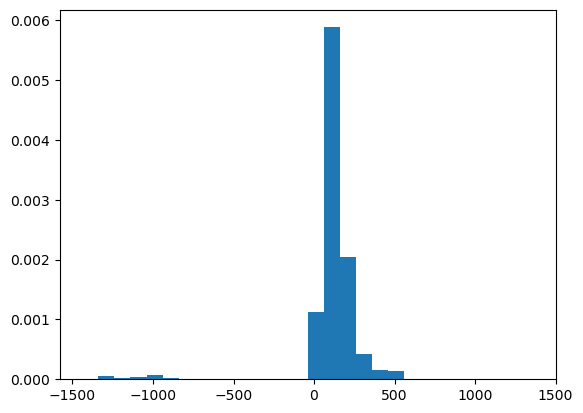

In [70]:
# Examine the difference between CRS Arrival and Departure times
bins = np.arange(-1440, 1440, 100)
plt.hist(flights['CRS_Arr_minus_Dep'], density=True,  bins = bins)
plt.show()

We can see that the time difference between arrival and departure can be negative or possitive but it seems that there is a certain gap in negative values. Let's zoom this part of the histogram in. 

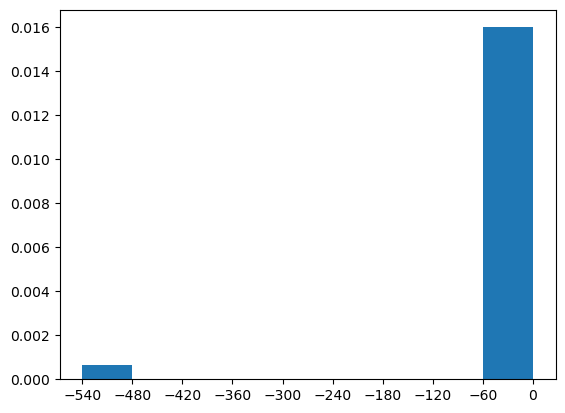

In [72]:
# Examine MORE CLOSELY the difference between CRS Arrival and Departure times 
bins = np.arange(-540, 60, 60)
plt.hist(flights['CRS_Arr_minus_Dep'], density=True,  bins = bins)
plt.xticks(bins)
plt.show()

We see that there is no negative values between -8 hours (-480 min) and -1 hour (-60 min). However, to be sure let's examine the data.

In [73]:
# Are there any values between -900 and -200
diff_between_900_200 = (flights['CRS_Arr_minus_Dep'] > -480) & (flights['CRS_Arr_minus_Dep'] < -60)
print(flights[diff_between_900_200])

del(diff_between_900_200)

Empty DataFrame
Columns: [FlightDate, Flight_Number_Reporting_Airline, Origin, Dest, CRSDepTime, DepTime, DepDelay, CRSArrTime, ArrTime, ArrDelay, Cancelled, Diverted, CRSElapsedTime, ActualElapsedTime, AirTime, CRSDepTime_min, CRSArrTime_min, DepTime_min, ArrTime_min, CRS_Arr_minus_Dep]
Index: []


Yes, there is no values between -480 and -60 minutes. 
It is possible to ‘travel in time’ only for a maximum of 60 minutes. All other differences occur when flights take off before midnight and land the next day. I can use a threshold of -60 minutes to adjust the departure date by adding one day in order to calculate the arrival date.

In [74]:
# Are there any values between -900 and -200
diff_greater_than_1300 = (flights['CRS_Arr_minus_Dep'] > 1300)
print(flights[diff_greater_than_1300])

del(diff_greater_than_1300)

Empty DataFrame
Columns: [FlightDate, Flight_Number_Reporting_Airline, Origin, Dest, CRSDepTime, DepTime, DepDelay, CRSArrTime, ArrTime, ArrDelay, Cancelled, Diverted, CRSElapsedTime, ActualElapsedTime, AirTime, CRSDepTime_min, CRSArrTime_min, DepTime_min, ArrTime_min, CRS_Arr_minus_Dep]
Index: []


There are no records with positive difference more than 1300 minutes, but when this occures it means the flight has arrived at the previouse day due to timezone difference. I will use this calculating arrival dates. 

### Calculating dates of departure and arrivel timezone naive 

#### Scheduled dates

In [75]:
# converting CRS times (departure and arrival into datetime with correct arrival date - the previous, the same or the next day)
flights['CRSDepDT'], flights['CRSArrDT'] = get_CRS_datetime(flights['FlightDate'], 
                                                                              flights['CRSDepTime_min'], 
                                                                              flights['CRSArrTime_min'])

In [78]:

# Check for actual departure and arrival datetimes 
pd.set_option('display.width', 200)

CRS_Arrived_next_day = flights['CRSArrTime_min'] - flights['CRSDepTime_min']  <= -60
CRS_Arrived_previous_day = flights['CRSArrTime_min'] - flights['CRSDepTime_min']  >= 1380
fields_to_check = ['FlightDate', 'CRSDepDT', 'CRSDepTime', 'CRSArrDT', 'CRSArrTime']
print('Flights arrived next day after departure\n', flights[CRS_Arrived_next_day][fields_to_check].head())
print('\nFlights arrived the same day as departured\n', flights[~CRS_Arrived_next_day][fields_to_check].head())
print('\nFlights arrived the previous day as departured\n', flights[CRS_Arrived_previous_day][fields_to_check].head())

pd.reset_option('display.width')

Flights arrived next day after departure
     FlightDate            CRSDepDT  CRSDepTime            CRSArrDT  CRSArrTime
259 2014-03-20 2014-03-20 20:40:00        2040 2014-03-21 00:05:00           5
529 2014-03-20 2014-03-20 21:50:00        2150 2014-03-21 00:15:00          15
559 2014-03-20 2014-03-20 17:55:00        1755 2014-03-21 00:30:00          30
569 2014-03-20 2014-03-20 17:15:00        1715 2014-03-21 00:20:00          20
578 2014-03-20 2014-03-20 17:40:00        1740 2014-03-21 00:50:00          50

Flights arrived the same day as departured
   FlightDate            CRSDepDT  CRSDepTime            CRSArrDT  CRSArrTime
0 2014-03-20 2014-03-20 07:00:00         700 2014-03-20 08:25:00         825
1 2014-03-20 2014-03-20 16:50:00        1650 2014-03-20 18:10:00        1810
2 2014-03-20 2014-03-20 09:05:00         905 2014-03-20 10:25:00        1025
3 2014-03-20 2014-03-20 07:05:00         705 2014-03-20 07:25:00         725
4 2014-03-20 2014-03-20 21:10:00        2110 2014-03-2

#### Actual dates

Calculating actual dates we have to take into account that even the departure date can differ from the dataset's 'FlightDate', because this date is for scheduled time, but actual time can move to the next or previous day due to flight positive or negative delay.

In [79]:
flights['ActDepDT'], flights['ActArrDT'] = get_Actual_datetime(flights['FlightDate'], 
                                                                flights['CRSDepTime_min'],
                                                                flights['DepTime_min'],
                                                                flights['ArrTime_min'],
                                                                flights['DepDelay'])

In [80]:
# Check for actual departure and arrival datetimes 
Arrived_next_day = flights['ArrTime_min'] - flights['DepTime_min']  <= -60
Arrived_previous_day = flights['ArrTime_min'] - flights['DepTime_min']  >= 1380
fields_to_check = ['FlightDate', 'CRSDepTime', 'DepDelay', 'ActDepDT', 'DepTime', 'ActArrDT', 'ArrTime']

print('\nFlights arrived next day after departure\n', flights[Arrived_next_day][fields_to_check].head())
print('\nFlights arrived the same day as departured\n', flights[~Arrived_next_day][fields_to_check].head())
print('\nFlights arrived the previous day as departured\n', flights[Arrived_previous_day][fields_to_check].head())


Flights arrived next day after departure
     FlightDate  CRSDepTime  DepDelay            ActDepDT  DepTime  \
80  2014-03-20        2130      59.0 2014-03-20 22:29:00   2229.0   
94  2014-03-20        2110     145.0 2014-03-20 23:35:00   2335.0   
108 2014-03-20        1910     236.0 2014-03-20 23:06:00   2306.0   
204 2014-03-20        1915     224.0 2014-03-20 22:59:00   2259.0   
259 2014-03-20        2040      29.0 2014-03-20 21:09:00   2109.0   

               ActArrDT  ArrTime  
80  2014-03-21 00:13:00     13.0  
94  2014-03-21 01:58:00    158.0  
108 2014-03-21 00:16:00     16.0  
204 2014-03-21 01:22:00    122.0  
259 2014-03-21 00:22:00     22.0  

Flights arrived the same day as departured
   FlightDate  CRSDepTime  DepDelay            ActDepDT  DepTime  \
0 2014-03-20         700       0.0 2014-03-20 07:00:00    700.0   
1 2014-03-20        1650      90.0 2014-03-20 18:20:00   1820.0   
2 2014-03-20         905       0.0 2014-03-20 09:05:00    905.0   
3 2014-03-20       

#### Converting datetimes to UTC timezone

In [81]:
# Converting scheduled (CRS) departure and arrival times into UTC timezone datetime
flights['CRSDep_UTC'] = convert_column_to_UTC(flights, 'CRSDepDT', 'Origin')
flights['CRSArr_UTC'] = convert_column_to_UTC(flights, 'CRSArrDT', 'Dest')

# Converting actual departure times into UTC timezone datetime
# We have to filter for non-NA values because astimezone doesn't work wiht NaN/NaT
nonNA_Dep = ~flights['ActDepDT'].isna()
flights['ActDep_UTC'] = pd.NaT
flights['ActDep_UTC'] = flights['ActDep_UTC'].dt.tz_localize(tz.UTC)
flights.loc[nonNA_Dep, 'ActDep_UTC'] = convert_column_to_UTC(flights[nonNA_Dep], 'ActDepDT', 'Origin')

# Converting actual arrival times into UTC timezone datetime
# We have to filter for non-NA values because astimezone doesn't work wiht NaN/NaT
nonNA_Arr = ~flights['ActArrDT'].isna()
flights['ActArr_UTC'] = pd.NaT
flights['ActArr_UTC'] = flights['ActArr_UTC'].dt.tz_localize(tz.UTC)
flights.loc[nonNA_Arr, 'ActArr_UTC'] = convert_column_to_UTC(flights[nonNA_Arr], 'ActArrDT', 'Dest')

In [84]:
with pd.option_context('display.width', 200):
    # Check CRS
    fields_to_check_UTC_CRS = ['CRSDepDT', 'CRSDep_UTC', 'CRSArrDT', 'CRSArr_UTC']
    print(flights[fields_to_check_UTC_CRS].head())

    # Check ACTUAL
    fields_to_check_UTC_Act = ['ActDepDT', 'ActDep_UTC', 'ActArrDT', 'ActArr_UTC']
    print(flights[fields_to_check_UTC_Act].head())

             CRSDepDT                CRSDep_UTC            CRSArrDT                CRSArr_UTC
0 2014-03-20 07:00:00 2014-03-20 13:00:00+00:00 2014-03-20 08:25:00 2014-03-20 14:25:00+00:00
1 2014-03-20 16:50:00 2014-03-20 22:50:00+00:00 2014-03-20 18:10:00 2014-03-21 00:10:00+00:00
2 2014-03-20 09:05:00 2014-03-20 15:05:00+00:00 2014-03-20 10:25:00 2014-03-20 16:25:00+00:00
3 2014-03-20 07:05:00 2014-03-20 13:05:00+00:00 2014-03-20 07:25:00 2014-03-20 14:25:00+00:00
4 2014-03-20 21:10:00 2014-03-21 03:10:00+00:00 2014-03-20 21:25:00 2014-03-21 04:25:00+00:00
             ActDepDT                ActDep_UTC            ActArrDT                ActArr_UTC
0 2014-03-20 07:00:00 2014-03-20 13:00:00+00:00 2014-03-20 08:11:00 2014-03-20 14:11:00+00:00
1 2014-03-20 18:20:00 2014-03-21 00:20:00+00:00 2014-03-20 19:30:00 2014-03-21 01:30:00+00:00
2 2014-03-20 09:05:00 2014-03-20 15:05:00+00:00 2014-03-20 10:18:00 2014-03-20 16:18:00+00:00
3 2014-03-20 07:02:00 2014-03-20 13:02:00+00:00 2014-03-20 0

#### Calculating scheduled and actual elapsed times based on UTC departure and arrival

In [85]:
# Calculating Elapsed time based on UTC times
flights['UTCElapsedTime_CRS'] = (flights['CRSArr_UTC'] - flights['CRSDep_UTC']).dt.total_seconds() / 60

flights.loc[nonNA_Arr, 'UTCElapsedTime_Act'] = pd.to_timedelta((flights.loc[nonNA_Arr, 'ActArr_UTC'] - 
                                                                flights.loc[nonNA_Arr, 'ActDep_UTC'])).dt.total_seconds() / 60



In [86]:
# The difference between UTC-based Elapsed time and CRS/ACTUAL Elapsed time
flights['diff_CRS'] = flights['UTCElapsedTime_CRS'] - flights['CRSElapsedTime']
flights['diff_Act'] = flights['UTCElapsedTime_Act'] - flights['ActualElapsedTime']

### Examining the accuracy of CRS Elapsed time

In [95]:
# Examine the flights having difference between UTC-Based and CRS Elapsed times 
diff_not_zero = flights[flights['diff_CRS'] != 0][fields_to_check_UTC_CRS + ['CRSElapsedTime', 'UTCElapsedTime_CRS']]
print('There are', len(diff_not_zero), 'flights where CRS Elapsed time differ from CRS Elapsed time culculated based on UTC')
print(diff_not_zero.head())

del(diff_not_zero)

There are 76 flights where CRS Elapsed time differ from CRS Elapsed time culculated based on UTC
                 CRSDepDT                CRSDep_UTC            CRSArrDT                CRSArr_UTC  CRSElapsedTime  UTCElapsedTime_CRS
86022 2014-03-08 23:00:00 2014-03-09 07:00:00+00:00 2014-03-09 01:50:00 2014-03-09 10:50:00+00:00           290.0               230.0
86031 2014-03-08 23:50:00 2014-03-09 07:50:00+00:00 2014-03-09 03:46:00 2014-03-09 11:46:00+00:00           296.0               236.0
86033 2014-03-08 23:05:00 2014-03-09 07:05:00+00:00 2014-03-09 01:56:00 2014-03-09 10:56:00+00:00           291.0               231.0
86262 2014-03-08 23:15:00 2014-03-09 09:15:00+00:00 2014-03-09 08:07:00 2014-03-09 15:07:00+00:00           412.0               352.0
86265 2014-03-08 23:55:00 2014-03-09 09:55:00+00:00 2014-03-09 08:31:00 2014-03-09 15:31:00+00:00           396.0               336.0


In [88]:
flights['diff_CRS'].value_counts()

diff_CRS
 0.0       503682
 1440.0        31
-1440.0        31
-60.0          13
-36.0           1
Name: count, dtype: int64

There are 76 flights in the datased where we have a difference between UTC and CRS elapsed time.


Let’s take a detailed look at one of these flights: the first one from the table above, with ID = 86022, which has a -60 minute difference between UTC and CRS elapsed times.

In [96]:
# Let's take a look on the first flight with diffeence
flights.iloc[86022]

FlightDate                               2014-03-08 00:00:00
Flight_Number_Reporting_Airline                          103
Origin                                                   SEA
Dest                                                     ANC
CRSDepTime                                              2300
DepTime                                               2347.0
DepDelay                                                47.0
CRSArrTime                                               150
ArrTime                                                206.0
ArrDelay                                                16.0
Cancelled                                              False
Diverted                                               False
CRSElapsedTime                                         290.0
ActualElapsedTime                                      259.0
AirTime                                                241.0
CRSDepTime_min                                          1380
CRSArrTime_min          

First, we see that this flight took place during the on March 9th 2014 - the spring start of DST, and the difference between UTC and CRS elapsed times is exactly 60 minutes. But which time is correct? Let’s take a look at similar flights on the other days.

In [97]:
flights[(flights['Flight_Number_Reporting_Airline'] == 103) &
         (flights['Origin'] == 'SEA')][['CRSArrTime', 'CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']]

,CRSArrTime,CRSElapsedTime,UTCElapsedTime_CRS,diff_CRS
84659,150,230.0,230.0,0.0
85219,150,230.0,230.0,0.0
85612,150,230.0,230.0,0.0
86022,150,290.0,230.0,-60.0
87954,2147,212.0,212.0,0.0
88114,150,230.0,230.0,0.0
88520,150,230.0,230.0,0.0
88902,150,230.0,230.0,0.0
89349,2147,212.0,212.0,0.0
90881,2147,212.0,212.0,0.0


It seems that the only flight having the difference is the filight landed 9th March 2014 and the UTC-based elapsed time is correct (CRSElapsedTime has the wrong value for DST day). Let's examine other flights having difference of 60 min.

In [100]:
diff_60_min = flights[flights['diff_CRS'] == -60][['CRSDepDT', 'CRSArrDT', 'CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']]
print(len(diff_60_min), 'records')
print(diff_60_min)

del(diff_60_min)

13 records
                 CRSDepDT            CRSArrDT  CRSElapsedTime  UTCElapsedTime_CRS  diff_CRS
86022 2014-03-08 23:00:00 2014-03-09 01:50:00           290.0               230.0     -60.0
86031 2014-03-08 23:50:00 2014-03-09 03:46:00           296.0               236.0     -60.0
86033 2014-03-08 23:05:00 2014-03-09 01:56:00           291.0               231.0     -60.0
86262 2014-03-08 23:15:00 2014-03-09 08:07:00           412.0               352.0     -60.0
86265 2014-03-08 23:55:00 2014-03-09 08:31:00           396.0               336.0     -60.0
86289 2014-03-08 20:55:00 2014-03-09 05:55:00           420.0               360.0     -60.0
86293 2014-03-08 22:30:00 2014-03-09 06:50:00           440.0               380.0     -60.0
86296 2014-03-08 22:10:00 2014-03-09 06:55:00           405.0               345.0     -60.0
86303 2014-03-08 23:55:00 2014-03-09 08:58:00           423.0               363.0     -60.0
86307 2014-03-08 20:50:00 2014-03-09 06:09:00           379.0        

We can see that all flights with a -60 minute difference between UTC and CRS elapsed times occurred during DST. There are 13 such records in the dataset.

We can conclude that the CRS elapsed time is incorrect for all 13 flights that passed through DST.

This explains the discrepancy between UTC and CRS elapsed times for 13 out of the 76 flights in the dataset. But what about the remaining flights with a difference?

In [101]:
flights['UTCElapsedTime_CRS'].describe()

count    503758.000000
mean        137.281445
std          75.220284
min        -975.000000
25%          84.000000
50%         119.000000
75%         170.000000
max        1875.000000
Name: UTCElapsedTime_CRS, dtype: float64

There is another interesting fact - some flights has also a negative UTC elapsed time! How is this possible?

In [103]:
error_less_0 = flights[flights['UTCElapsedTime_CRS'] < 0]
print('Number of flihgts with negative UTC-based duration:', len(error_less_0))
error_less_0[
    ['CRSDepTime', 
     'Origin', 
     'CRSArrTime', 
     'Dest', 
     'CRSElapsedTime', 
     'UTCElapsedTime_CRS', 
     'diff_CRS']]

Number of flihgts with negative UTC-based duration: 31


,CRSDepTime,Origin,CRSArrTime,Dest,CRSElapsedTime,UTCElapsedTime_CRS,diff_CRS
355885,1415,HNL,1800,GUM,465.0,-975.0,-1440.0
356594,1415,HNL,1800,GUM,465.0,-975.0,-1440.0
357533,1405,HNL,1755,GUM,470.0,-970.0,-1440.0
359004,1405,HNL,1755,GUM,470.0,-970.0,-1440.0
363144,1405,HNL,1755,GUM,470.0,-970.0,-1440.0
363988,1405,HNL,1755,GUM,470.0,-970.0,-1440.0
365214,1405,HNL,1755,GUM,470.0,-970.0,-1440.0
366081,1405,HNL,1755,GUM,470.0,-970.0,-1440.0
367783,1405,HNL,1755,GUM,470.0,-970.0,-1440.0
368046,1405,HNL,1755,GUM,470.0,-970.0,-1440.0


There are 31 flights with a negative UTC elapsed time. Previously, we analyzed the differences between UTC and CRS elapsed times and found that 31 flights had a -1440 minute difference. These are the same flights. A difference of 1440 minutes is equivalent to 24 hours.

All 31 flights were from HNL to GUM, which is interesting because HNL is in the UTC-10 timezone, while GUM is in the UTC+10 timezone. These two airports are located across the International Date Line (IDL).

In [104]:
print(error_less_0[['CRSDep_UTC', 'CRSDepTime', 'Origin', 'CRSArr_UTC', 'CRSArrTime', 'Dest', 'diff_CRS']].head())

del(error_less_0)

                      CRSDep_UTC  CRSDepTime Origin                CRSArr_UTC  CRSArrTime Dest  diff_CRS
355885 2014-04-01 00:15:00+00:00        1415    HNL 2014-03-31 08:00:00+00:00        1800  GUM   -1440.0
356594 2014-03-31 00:15:00+00:00        1415    HNL 2014-03-30 08:00:00+00:00        1800  GUM   -1440.0
357533 2014-03-28 00:05:00+00:00        1405    HNL 2014-03-27 07:55:00+00:00        1755  GUM   -1440.0
359004 2014-03-29 00:05:00+00:00        1405    HNL 2014-03-28 07:55:00+00:00        1755  GUM   -1440.0
363144 2014-03-27 00:05:00+00:00        1405    HNL 2014-03-26 07:55:00+00:00        1755  GUM   -1440.0


The easiest way to correct this is to find all flight with UTC Departures less than UTC Arrival and add 24 x 60 minutes to the UTC Elapsed time

There ara other flights which have the "oposite" difference - they differ on +1440 minutes. 

In [105]:
error_plus_1440 = flights[flights['diff_CRS'] == 1440]
print(len(error_plus_1440))
print(error_plus_1440[['CRSDep_UTC', 'CRSDepTime', 'Origin', 'CRSArr_UTC', 'CRSArrTime', 'Dest', 'diff_CRS']])

del(error_plus_1440)

31
                      CRSDep_UTC  CRSDepTime Origin                CRSArr_UTC  CRSArrTime Dest  diff_CRS
355883 2014-03-30 20:30:00+00:00         630    GUM 2014-04-01 03:45:00+00:00        1745  HNL    1440.0
356592 2014-03-29 20:30:00+00:00         630    GUM 2014-03-31 03:45:00+00:00        1745  HNL    1440.0
357531 2014-03-26 20:40:00+00:00         640    GUM 2014-03-28 03:40:00+00:00        1740  HNL    1440.0
359002 2014-03-27 20:40:00+00:00         640    GUM 2014-03-29 03:40:00+00:00        1740  HNL    1440.0
363142 2014-03-25 20:40:00+00:00         640    GUM 2014-03-27 03:40:00+00:00        1740  HNL    1440.0
363986 2014-03-23 20:40:00+00:00         640    GUM 2014-03-25 03:40:00+00:00        1740  HNL    1440.0
365212 2014-03-24 20:40:00+00:00         640    GUM 2014-03-26 03:40:00+00:00        1740  HNL    1440.0
366079 2014-03-22 20:40:00+00:00         640    GUM 2014-03-24 03:40:00+00:00        1740  HNL    1440.0
367781 2014-03-19 20:40:00+00:00         640    GUM 

All these flight are back flights from GUM to HLN across Internation Date Line (IDL). The ramedy is simillar - to subtract 24 x 60 (1440) minutes from UTC elapsed time. 

There is just one flight with unexamined yet difference. 

In [106]:
error_minus_36 = flights[flights['diff_CRS'] == -36]
print(len(error_minus_36), 'records')
print(error_minus_36[['Flight_Number_Reporting_Airline', 'CRSDep_UTC', 'CRSDepTime', 'Origin', 'CRSArr_UTC', 
               'CRSArrTime', 'Dest', 'CRSElapsedTime', 'UTCElapsedTime_CRS', 
               'ActualElapsedTime', 'diff_CRS', 'Cancelled', 'Diverted']].T)

del(error_minus_36)

1 records
                                                    253577
Flight_Number_Reporting_Airline                        317
CRSDep_UTC                       2014-03-30 14:05:00+00:00
CRSDepTime                                             805
Origin                                                 DEN
CRSArr_UTC                       2014-03-30 16:14:00+00:00
CRSArrTime                                             914
Dest                                                   PSP
CRSElapsedTime                                       165.0
UTCElapsedTime_CRS                                   129.0
ActualElapsedTime                                      NaN
diff_CRS                                             -36.0
Cancelled                                            False
Diverted                                              True


In [107]:
flights[(flights['Flight_Number_Reporting_Airline'] == 317) &
        (flights['Origin'] == 'DEN') &
        (flights['Dest'] == 'PSP')] [['CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']]

,CRSElapsedTime,UTCElapsedTime_CRS,diff_CRS
246801,129.0,129.0,0.0
247742,129.0,129.0,0.0
247840,129.0,129.0,0.0
248214,129.0,129.0,0.0
248832,129.0,129.0,0.0
249571,129.0,129.0,0.0
250063,129.0,129.0,0.0
250962,129.0,129.0,0.0
251072,129.0,129.0,0.0
251378,129.0,129.0,0.0


In this case we see that CRS Elapsed time is:
1. also inconsistent with CRS Departure and CRS Arrival times
2. all other flights for this route have the equal CRS and UTC elapsed times which is 129 minutes  

So this can be an error

### Checking ACTUAL time

In [108]:
flights['diff_Act'].value_counts()

diff_Act
 0.0       492965
-1440.0        30
 1440.0        30
-60.0          15
-6.0            1
 5.0            1
-51.0           1
Name: count, dtype: int64

It appears that the actual elapsed time shows the same differences as the scheduled elapsed time between the two types of flight duration: one calculated using UTC arrival and departure times, and the other based on the ActualElapsedTime provided in the dataset. Let’s take a closer look.

The total number of discrepancies is 78, with the following breakdown:
*	+/-1440 minutes: 60 records, likely related to flights crossing the International Date Line (IDL) from HNL to GUM and back.
*	-60 minutes: 15 records, possibly due to flights occurring during the transition to Daylight Saving Time (DST) in the spring.
*	Other: 3 records with small, random differences, which could be attributed to minor errors.

In [109]:
error_1440 = flights[flights['diff_Act'].isin([1440, -1440])]
print('There are:', len(error_1440), 'records with differenc +/-1440 min (equal to 24 hours)')
print('Which airports are presented among these flights? -', *set(error_1440['Origin']).union(set(error_1440['Origin'])))

del(error_1440)

There are: 60 records with differenc +/-1440 min (equal to 24 hours)
Which airports are presented among these flights? - GUM HNL


All these flights are again between two airports across IDL. We already know this problem and know how to cue it. 

In [113]:
# Let's check the flights with difference between actual and UTC-based actual duration equal to -60 minutes
fields_to_check = ['Flight_Number_Reporting_Airline', 'ActDepDT', 'ActArrDT',
                   'Origin', 'Dest', 'ActualElapsedTime', 'UTCElapsedTime_Act']
error_60 = flights[flights['diff_Act'] == -60][fields_to_check]

In [114]:
# Converting datetimes naive to tz-aware datetimes
error_60['ActDepDT_tz'] = add_local_tz(error_60, 'ActDepDT', 'Origin')
error_60['ActArrDT_tz'] = add_local_tz(error_60, 'ActArrDT', 'Dest')

print(error_60[fields_to_check])
print('There are', len(error_60), 'flights with -60 minutes difference')

        Flight_Number_Reporting_Airline            ActDepDT            ActArrDT Origin Dest  ActualElapsedTime  UTCElapsedTime_Act
86031                               121 2014-03-09 00:10:00 2014-03-09 03:39:00    SEA  ANC              269.0               209.0
86033                               125 2014-03-08 23:03:00 2014-03-09 01:38:00    SEA  FAI              275.0               215.0
86262                               816 2014-03-08 23:15:00 2014-03-09 07:28:00    LIH  SEA              373.0               313.0
86265                               822 2014-03-08 23:50:00 2014-03-09 07:42:00    OGG  PDX              352.0               292.0
86289                               864 2014-03-08 21:06:00 2014-03-09 05:21:00    HNL  SEA              375.0               315.0
86293                               871 2014-03-08 22:22:00 2014-03-09 06:51:00    HNL  ANC              449.0               389.0
86296                               878 2014-03-08 21:56:00 2014-03-09 06:05:00    

All these flights departured before the transition to DST and arrived after it (except one flight 125 from SEA to FAI). This is the reason they have a wrong ActualElapsedTime. It's worth to mention that theirs arrival time is correct because UTC-based durations have correct values (UTC-based duration is calculated based on departure and arrival times).


In [115]:
flights[(flights['Flight_Number_Reporting_Airline'] == 125) &
         (flights['Origin'] == 'SEA') &
         (flights['Dest'] == 'FAI')] [['Flight_Number_Reporting_Airline', 
                                       'ActDepDT', 'ActArrDT', 
                                       'Origin', 'Dest', 
                                       'ActualElapsedTime', 'UTCElapsedTime_Act', 'diff_CRS']]

,Flight_Number_Reporting_Airline,ActDepDT,ActArrDT,Origin,Dest,ActualElapsedTime,UTCElapsedTime_Act,diff_CRS
84672,125,2014-03-06 22:57:00,2014-03-07 01:34:00,SEA,FAI,217.0,217.0,0.0
85230,125,2014-03-01 23:05:00,2014-03-02 01:50:00,SEA,FAI,225.0,225.0,0.0
85624,125,2014-03-02 23:04:00,2014-03-03 01:36:00,SEA,FAI,212.0,212.0,0.0
86033,125,2014-03-08 23:03:00,2014-03-09 01:38:00,SEA,FAI,275.0,215.0,-60.0
88127,125,2014-03-03 23:05:00,2014-03-04 01:42:00,SEA,FAI,217.0,217.0,0.0
88533,125,2014-03-04 22:56:00,2014-03-05 01:38:00,SEA,FAI,222.0,222.0,0.0
88915,125,2014-03-05 23:10:00,2014-03-06 01:55:00,SEA,FAI,225.0,225.0,0.0
96547,125,2014-03-07 23:04:00,2014-03-08 01:29:00,SEA,FAI,205.0,205.0,0.0


The flight 125 from SEA to FAI has the wrong Actual Elapsed time only on March 9th 2014. On all other days the actual elapsed times are equil to UTC-based actual elapsed time. 

Let's analyse remaining flights with differencies

In [116]:
fields_to_check = ['Flight_Number_Reporting_Airline',
       'ActDepDT', 
       'ActArrDT',
       'Origin', 
       'Dest', 
       'ActDep_UTC',
       'ActArr_UTC',
       'diff_Act', 
       'ActualElapsedTime', 
       'UTCElapsedTime_Act']
other = flights[(flights['diff_Act'] > -60) & (flights['diff_Act'] < 10) & (flights['diff_Act'] != 0)]
print(len(other))
other[fields_to_check].T

3


,86022,86023,233975
Flight_Number_Reporting_Airline,103,106,5702
ActDepDT,2014-03-08 23:47:00,2014-03-08 21:33:00,2014-03-09 00:20:00
ActArrDT,2014-03-09 02:06:00,2014-03-09 02:55:00,2014-03-09 02:51:00
Origin,SEA,ANC,ORD
Dest,ANC,SEA,CAE
ActDep_UTC,2014-03-09 07:47:00+00:00,2014-03-09 06:33:00+00:00,2014-03-09 06:20:00+00:00
ActArr_UTC,2014-03-09 12:00:00+00:00,2014-03-09 10:00:00+00:00,2014-03-09 07:00:00+00:00
diff_Act,-6.0,5.0,-51.0
ActualElapsedTime,259.0,202.0,91.0
UTCElapsedTime_Act,253.0,207.0,40.0


First of all, we notice that all these differences appear again on the spring DST start date.
Secondly, it looks like the first two flights have minor errors that we can disregard, and we can use UTC elapsed time instead of Actual elapsed time. However, the third flight has a significant difference. Let’s examine it in more detail.

In [117]:
flights[(flights['Flight_Number_Reporting_Airline'] == 5702) &\
        (flights['Origin'] == 'ORD') & (flights['Dest'] == 'CAE')] [fields_to_check]

,Flight_Number_Reporting_Airline,ActDepDT,ActArrDT,Origin,Dest,ActDep_UTC,ActArr_UTC,diff_Act,ActualElapsedTime,UTCElapsedTime_Act
233969,5702,NaT,NaT,ORD,CAE,NaT,NaT,NaN,NaN,NaN
233970,5702,NaT,NaT,ORD,CAE,NaT,NaT,NaN,NaN,NaN
233971,5702,2014-03-01 21:45:00,2014-03-02 00:25:00,ORD,CAE,2014-03-02 03:45:00+00:00,2014-03-02 05:25:00+00:00,0.0,100.0,100.0
233972,5702,2014-03-04 20:47:00,2014-03-04 23:40:00,ORD,CAE,2014-03-05 02:47:00+00:00,2014-03-05 04:40:00+00:00,0.0,113.0,113.0
233973,5702,2014-03-02 18:22:00,2014-03-02 21:09:00,ORD,CAE,2014-03-03 00:22:00+00:00,2014-03-03 02:09:00+00:00,0.0,107.0,107.0
233974,5702,2014-03-06 21:53:00,2014-03-07 00:54:00,ORD,CAE,2014-03-07 03:53:00+00:00,2014-03-07 05:54:00+00:00,0.0,121.0,121.0
233975,5702,2014-03-09 00:20:00,2014-03-09 02:51:00,ORD,CAE,2014-03-09 06:20:00+00:00,2014-03-09 07:00:00+00:00,-51.0,91.0,40.0
233976,5702,2014-03-07 18:08:00,2014-03-07 20:52:00,ORD,CAE,2014-03-08 00:08:00+00:00,2014-03-08 01:52:00+00:00,0.0,104.0,104.0
233977,5702,2014-03-15 19:36:00,2014-03-15 22:20:00,ORD,CAE,2014-03-16 00:36:00+00:00,2014-03-16 02:20:00+00:00,0.0,104.0,104.0
233978,5702,2014-03-13 18:37:00,2014-03-13 21:12:00,ORD,CAE,2014-03-13 23:37:00+00:00,2014-03-14 01:12:00+00:00,0.0,95.0,95.0


We observe that the same flight on other days has a duration close to the actual elapsed time recorded on March 9th. The elapsed time based on UTC, however, is significantly different from the real duration, which suggests that either the actual departure or arrival time (or both) is incorrect. There are several options to address this, such as adjusting the departure or arrival time based on the average duration of similar flights. However, due to the insignificance of this error (1 out of almost 500k flights in total, and 25 flights on this route in the same month), the simplest solution is to drop this record on the next stage.

### Conclusions for evaluation of the accuracy of Scheduled and Actual Elapsed Times  
1. The most of data accurate
2. The flights across IDL (particularly GUM and HNL airports) reqieres substructuo of 1440 minutes (24hours) due to the date change.
3. The start (and probably the end) of DST creates minor errors in elapsed time calculation and requires correction.
4. Therea are absulute minorite of flights that have indiscrepencies between elapsed time and departur and arrival time (3 flight for more about 500k records for March 2014.)

## Data transformation

### Preprocessing all 60 data files (one file - one month)

In [118]:
fields_to_load = {
    # 'Year':                 np.int16,               
    # 'Quarter':              np.int8,                
    # 'Month':                np.int8,                
    # 'DayofMonth':           np.int8,
    # 'DayOfWeek':            np.int8,
    'FlightDate':           'str',
    'Reporting_Airline':    'category',
    'Flight_Number_Reporting_Airline':  np.int16,
    # 'OriginAirportID':      'category',
    'Origin':               'category',
    # 'DestAirportID':        'category',
    'Dest':                 'category',
    'CRSDepTime':           np.int16,
    'DepTime':              'float32',
    'DepDelay':             'float32',
    'DepartureDelayGroups': 'category',
    'DepTimeBlk':           'category',
    'CRSArrTime':           np.int16,
    'ArrTime':              'float32',
    'ArrDelay':             'float32',
    # 'Distance':             'float32',
    'ArrivalDelayGroups':   'category',
    'ArrTimeBlk':           'category',
    'Cancelled':            np.int8,        # boolean
    'CancellationCode':     'category',
    'Diverted':             np.int8,        # boolean
    'CarrierDelay':         'float32',
    'WeatherDelay':         'float32',
    'NASDelay':             'float32',
    'SecurityDelay':        'float32',
    'LateAircraftDelay':    'float32',
    'CRSElapsedTime':       'float32',
    'ActualElapsedTime':    'float32',
    'AirTime':              'float32',
    'DivReachedDest':       'float32',      # boolean
    'DivActualElapsedTime': 'float32',
    'DivArrDelay':          'float32'}

In [119]:
source_zip = 'data/interim/csv_flight.zip'
source_path = 'csv_flight/report_'
counter = 0
total_time = 0

# Fields to downcast type from 'float32' to 'float16'
downcast_fields = ['DepDelay', 'ArrDelay', 'CarrierDelay', 'WeatherDelay','NASDelay', 'SecurityDelay', 'LateAircraftDelay', 
                   'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'DivActualElapsedTime', 'DivArrDelay', 'UTCElapsedTime_CRS',
                   'UTCElapsedTime_Act', 'diff_CRS', 'diff_Act']

for year in range(2014, 2019):
    for month in range(1, 13): 
        t_start = time()
        counter += 1
        source_data = source_path + str(year) + '_' + str(month) + '.csv'
        print(source_data + ' ', end='')

        flights = pd.DataFrame()
        flights = load_data_from(source_zip, source_data, fields_to_load)

        flights['CRSArrTime_min'] = time_to_minutes(flights['CRSArrTime'])
        flights['CRSDepTime_min'] = time_to_minutes(flights['CRSDepTime'])
        flights['ArrTime_min'] = time_to_minutes(flights['ArrTime'])
        flights['DepTime_min'] = time_to_minutes(flights['DepTime'])

        flights['CRSDepDT'], flights['CRSArrDT'] = get_CRS_datetime(flights['FlightDate'], 
                                                                    flights['CRSDepTime_min'], 
                                                                    flights['CRSArrTime_min'])

        flights['DepDT'], flights['ArrDT'] = get_Actual_datetime(flights['FlightDate'],
                                                                flights['CRSDepTime_min'],  
                                                                flights['DepTime_min'], 
                                                                flights['ArrTime_min'],
                                                                flights['DepDelay'])

        # Getting UTC timezone for scheduled (CRS) departure and arrival times
        flights['CRSDep_UTC'] = convert_column_to_UTC(flights, 'CRSDepDT', 'Origin')
        flights['CRSArr_UTC'] = convert_column_to_UTC(flights, 'CRSArrDT', 'Dest')

        # We have to filter for non-NA values because astimezone doesn't work wiht NaN/NaT
        nonNA_Dep = ~flights['DepTime'].isna()
        flights['ActDep_UTC'] = pd.NaT
        flights['ActDep_UTC'] = flights['ActDep_UTC'].dt.tz_localize(tz.UTC)
        flights.loc[nonNA_Dep, 'ActDep_UTC'] = pd.to_datetime(convert_column_to_UTC(flights[nonNA_Dep], 'DepDT', 'Origin'))

        # We have to filter for non-NA values because astimezone doesn't work wiht NaN/NaT
        nonNA_Arr = ~flights['ArrTime'].isna()
        flights['ActArr_UTC'] = pd.NaT
        flights['ActArr_UTC'] = flights['ActArr_UTC'].dt.tz_localize(tz.UTC)
        flights.loc[nonNA_Arr, 'ActArr_UTC'] = convert_column_to_UTC(flights[nonNA_Arr], 'ArrDT', 'Dest')

        # Calculating Elapsed time based on UTC times
        flights['UTCElapsedTime_CRS'] = (flights['CRSArr_UTC'] - flights['CRSDep_UTC']).dt.total_seconds() / 60
        flights.loc[nonNA_Arr, 'UTCElapsedTime_Act'] = pd.to_timedelta((flights.loc[nonNA_Arr, 'ActArr_UTC'] - 
                                                                flights.loc[nonNA_Arr, 'ActDep_UTC'])).dt.total_seconds() / 60



        flights['diff_CRS'] = flights['UTCElapsedTime_CRS'] - flights['CRSElapsedTime']
        flights['diff_Act'] = flights['UTCElapsedTime_Act'] - flights['ActualElapsedTime']
       
        # Cleaning the dataset
        flights.drop(['FlightDate', 
                    'DepTime', 'DepTime_min', 'ArrTime', 'ArrTime_min',
                    'CRSDepTime', 'CRSDepTime_min', 'CRSArrTime', 'CRSArrTime_min'], axis = 1, inplace = True)
        flights[downcast_fields] = flights[downcast_fields].astype('float16')

        # Export data
        output_file_name = 'data/processed/processed_' + str(year) + '_' + str(month) + '.pickle'
        with open(output_file_name, 'wb') as out_file:
            pickle.dump(flights, out_file, protocol=pickle.HIGHEST_PROTOCOL)

        t_end = time()
        elapsed_t = t_end - t_start
        total_time += elapsed_t
        print(round(elapsed_t, 1), 'sec, total time:', round(total_time, 1), \
            'sec, avg: ', round(total_time / counter, 1), 'sec, remaining time (estimate)', 
            round(total_time / counter * (60 - counter) /60), 'min.')

print('\nTotal files:', counter)
print('Total time:', round(total_time / 60, 1), 'min')
print('Average time:', round(total_time / counter, 1), 'sec')
del(flights)

csv_flight/report_2014_1.csv 49.9 sec, total time: 49.9 sec, avg:  49.9 sec, remaining time (estimate) 49 min.
csv_flight/report_2014_2.csv 45.6 sec, total time: 95.5 sec, avg:  47.8 sec, remaining time (estimate) 46 min.
csv_flight/report_2014_3.csv 55.0 sec, total time: 150.6 sec, avg:  50.2 sec, remaining time (estimate) 48 min.
csv_flight/report_2014_4.csv 52.7 sec, total time: 203.3 sec, avg:  50.8 sec, remaining time (estimate) 47 min.
csv_flight/report_2014_5.csv 54.4 sec, total time: 257.7 sec, avg:  51.5 sec, remaining time (estimate) 47 min.
csv_flight/report_2014_6.csv 55.9 sec, total time: 313.6 sec, avg:  52.3 sec, remaining time (estimate) 47 min.
csv_flight/report_2014_7.csv 55.8 sec, total time: 369.5 sec, avg:  52.8 sec, remaining time (estimate) 47 min.
csv_flight/report_2014_8.csv 54.6 sec, total time: 424.1 sec, avg:  53.0 sec, remaining time (estimate) 46 min.
csv_flight/report_2014_9.csv 50.3 sec, total time: 474.5 sec, avg:  52.7 sec, remaining time (estimate) 45

In [120]:
print('Total files:', counter)
print('Total time:', round(total_time / 60, 1), 'min')
print('Average time:', round(total_time / counter, 1), 'sec')

Total files: 60
Total time: 54.3 min
Average time: 54.3 sec


### Loading the total dataset

In [167]:
flights = pd.DataFrame()
flights_list = []
for year in range(2014, 2019):
    for month in range(1, 13): 
        input_file_name = 'data/processed/processed_' + str(year) + '_' + str(month) + '.pickle'
        print(input_file_name)
        with open(input_file_name, 'rb') as in_file:
            flights_list.append(pickle.load(in_file))

flights = pd.concat(flights_list, axis=0, ignore_index=True)
del(flights_list)

data/processed/processed_2014_1.pickle
data/processed/processed_2014_2.pickle
data/processed/processed_2014_3.pickle
data/processed/processed_2014_4.pickle
data/processed/processed_2014_5.pickle
data/processed/processed_2014_6.pickle
data/processed/processed_2014_7.pickle
data/processed/processed_2014_8.pickle
data/processed/processed_2014_9.pickle
data/processed/processed_2014_10.pickle
data/processed/processed_2014_11.pickle
data/processed/processed_2014_12.pickle
data/processed/processed_2015_1.pickle
data/processed/processed_2015_2.pickle
data/processed/processed_2015_3.pickle
data/processed/processed_2015_4.pickle
data/processed/processed_2015_5.pickle
data/processed/processed_2015_6.pickle
data/processed/processed_2015_7.pickle
data/processed/processed_2015_8.pickle
data/processed/processed_2015_9.pickle
data/processed/processed_2015_10.pickle
data/processed/processed_2015_11.pickle
data/processed/processed_2015_12.pickle
data/processed/processed_2016_1.pickle
data/processed/proc

In [168]:
# There 35 flights which doesn't have CRS Elapsed Time 
# I will assign UTC Elapsed TIme (CRS) to CRS Elapsed Time for these flights
# and set their diff_CRS field to 0

flights_with_zero_CRS_ET = flights['CRSElapsedTime'].isna()

print('Number of records with NaN CRS Elapsed Time before:', flights['CRSElapsedTime'].isna().sum())
flights[flights_with_zero_CRS_ET][['CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS', 'CRSDepDT', 'CRSArrDT']]
flights.loc[flights_with_zero_CRS_ET, 'CRSElapsedTime'], flights.loc[flights_with_zero_CRS_ET, 'diff_CRS'] = \
    flights.loc[flights_with_zero_CRS_ET, 'UTCElapsedTime_CRS'],  0
print('Number of records with NaN CRS Elapsed Time before:', flights['CRSElapsedTime'].isna().sum())


Number of records with NaN CRS Elapsed Time before: 35
Number of records with NaN CRS Elapsed Time before: 0


Let's check the memory usage

In [169]:
memory_usage_per_type(flights)
print('Memory usage by dataframe {:.2f} MB'.format(memory_usage(flights)) )

memory usage for number columns: 977.437 MB
memory usage for object columns: 5384.177 MB
memory usage for datetimetz columns: 919.941 MB
memory usage for category columns: 114.998 MB
memory usage for bool columns: 86.245 MB
Memory usage by dataframe 8402.74 MB


All 'category' fileds become 'object' and use a lot of memory. Let's change them back to 'category' to save memory

In [170]:
category_fields = ['Reporting_Airline', 'Origin', 'Dest', 'CancellationCode']
flights[category_fields] = flights[category_fields].astype('category')

In [171]:
print(flights.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30144615 entries, 0 to 30144614
Data columns (total 36 columns):
 #   Column                           Dtype                  
---  ------                           -----                  
 0   Reporting_Airline                category               
 1   Flight_Number_Reporting_Airline  int16                  
 2   Origin                           category               
 3   Dest                             category               
 4   DepDelay                         float16                
 5   DepartureDelayGroups             category               
 6   DepTimeBlk                       category               
 7   ArrDelay                         float16                
 8   ArrivalDelayGroups               category               
 9   ArrTimeBlk                       category               
 10  Cancelled                        bool                   
 11  CancellationCode                 category               
 12  Diverted    

In [172]:
memory_usage_per_type(flights)
print('Memory usage by dataframe {:.2f} MB'.format(memory_usage(flights)) )

memory usage for number columns: 977.437 MB
memory usage for object columns: 0.000 MB
memory usage for datetimetz columns: 919.941 MB
memory usage for category columns: 287.542 MB
memory usage for bool columns: 86.245 MB
Memory usage by dataframe 3191.10 MB


In [173]:
output_file_name = 'data/processed/processed_2014_2018.pickle'
with open(output_file_name, 'wb') as out_file:
    pickle.dump(flights, out_file, protocol=pickle.HIGHEST_PROTOCOL)

### Correcting elapsed times errrors

In [6]:
input_file_name = 'data/processed/processed_2014_2018.pickle'
with open(input_file_name, 'rb') as in_file:
    flights = pickle.load(in_file)

#### Scheduled (CRS) and UTC_based scheduled elapsed times

In [21]:
flights['diff_CRS'].value_counts()

diff_CRS
 0.0       30140198
-1440.0        1827
 1440.0        1826
-60.0           251
 60.0           180
             ...   
 6.0              1
 1315.0           1
 67.0             1
 160.0            1
 61.0             1
Name: count, Length: 113, dtype: int64

We see 2880 errors caused by IDL which we already know about. Let's rectify it.

In [22]:
pd.set_option('display.width', 200)
correct_IDL(flights, 'CRS')
correct_IDL(flights, 'Act')
pd.reset_option('display.width')

         Origin Dest            CRSDepDT            CRSArrDT                CRSDep_UTC                CRSArr_UTC  CRSElapsedTime  UTCElapsedTime_CRS  diff_CRS
138284      GUM  HNL 2014-01-22 07:15:00 2014-01-22 18:15:00 2014-01-21 21:15:00+00:00 2014-01-23 04:15:00+00:00           420.0              1860.0    1440.0
138286      HNL  GUM 2014-01-22 14:50:00 2014-01-22 18:40:00 2014-01-23 00:50:00+00:00 2014-01-22 08:40:00+00:00           470.0              -970.0   -1440.0
162264      GUM  HNL 2014-01-09 07:15:00 2014-01-09 18:15:00 2014-01-08 21:15:00+00:00 2014-01-10 04:15:00+00:00           420.0              1860.0    1440.0
162266      HNL  GUM 2014-01-09 14:50:00 2014-01-09 18:40:00 2014-01-10 00:50:00+00:00 2014-01-09 08:40:00+00:00           470.0              -970.0   -1440.0
295788      GUM  HNL 2014-01-31 07:15:00 2014-01-31 18:15:00 2014-01-30 21:15:00+00:00 2014-02-01 04:15:00+00:00           420.0              1860.0    1440.0
...         ...  ...                 ...      

In [23]:
print(flights['diff_CRS'].value_counts())
print('Total number of records with different CRS Elapsed time (UTC-based vs. source data):', (flights['diff_CRS'] != 0).sum())
print(flights['diff_Act'].value_counts())
print('Total number of records with different Actual Elapsed time (UTC-based vs. source data):', ((flights['diff_Act'] != 0) & (~flights['diff_Act'].isna())).sum())


diff_CRS
 0.0       30143851
-60.0           251
 60.0           180
 1.0            103
-1.0             31
             ...   
 6.0              1
 1315.0           1
 67.0             1
 160.0            1
 61.0             1
Name: count, Length: 111, dtype: int64
Total number of records with different CRS Elapsed time (UTC-based vs. source data): 764
diff_Act
 0.0      29588477
-60.0          158
 60.0          123
 1.0            91
-1.0            31
 120.0          11
 2.0             4
-10.0            4
-8.0             3
-21.0            3
-2.0             3
-40.0            3
-19.0            3
 5.0             2
-41.0            2
 11.0            2
-7.0             2
-4.0             1
 27.0            1
 4.0             1
-51.0            1
 67.0            1
 41.0            1
-20.0            1
-31.0            1
 16.0            1
-70.0            1
-32.0            1
-26.0            1
-33.0            1
 40.0            1
-6.0             1
-16.0            1
-9.0   

Now we don't see records with the difference of +/-1440 minutes, so the problem was solved, recordeds were rectified by correcting datetimes and durations by 1440 minutes (24h)

In [24]:
print(flights.groupby(['Cancelled', 'Diverted'])[['diff_CRS', 'diff_Act']].count())

                    diff_CRS  diff_Act
Cancelled Diverted                    
False     False     29588947  29588945
          True         73662         0
True      False       481991         0
          True            15         0


There is a difference in the number of flights that neither was Cancelled or Diverted in 2 flights: 28.588,947 have some value at 'diff_CRS' column, but only 25.588.945 of them have value at 'diff_Act' column. It seems unusual becase all flights, that were not Cancelled or Diverted have to have some not_NaN value. Let's take a look on these records.

In [25]:
with pd.option_context('display.width', 200):
    print(flights[~flights['Cancelled'] & ~flights['Diverted'] & flights['diff_Act'].isna()].T)

                                                  18948325                   24350329
Reporting_Airline                                       F9                         YX
Flight_Number_Reporting_Airline                        920                       6103
Origin                                                 MCO                        LGA
Dest                                                   TTN                        DFW
DepDelay                                              35.0                       -3.0
DepartureDelayGroups                                     2                         -1
DepTimeBlk                                       2000-2059                  0900-0959
ArrDelay                                               NaN                        9.0
ArrivalDelayGroups                                     NaN                          0
ArrTimeBlk                                       2300-2359                  1300-1359
Cancelled                                            F

Both these flights lack Air Time and Actual Elapsed Time (so they didn’t fly?). Despite this, one of them even shows an Actual Arrival Time 283 minutes after the Actual Departure Time.

I’m planning to delete both of these records.”

In [26]:
print('Number of records BEFORE the deletion: {:,d}'.format(len(flights)))
flights = flights[~(~flights['Cancelled'] & ~flights['Diverted'] & flights['diff_Act'].isna())]
print('Number of records AFTER the deletion: {:,d}'.format(len(flights)))

Number of records BEFORE the deletion: 30,144,615
Number of records AFTER the deletion: 30,144,613


In [27]:
print('Total number of dlights: {:,d}'.format(total := len(flights)))
print('Flghts that were cancelled or diverted (have NaN \'diff_Act\'): {:,d}'.format(NA_diff_act := flights['diff_Act'].isna().sum()))
print('The difference between total number of records and not NaN \'diff_Act\': {:,d}'.format(total - NA_diff_act))
print('The number of \'diff_CRS\' with NaM values: {:,d}'.format(flights['diff_CRS'].isna().sum()))

Total number of dlights: 30,144,613
Flghts that were cancelled or diverted (have NaN 'diff_Act'): 555,668
The difference between total number of records and not NaN 'diff_Act': 29,588,945
The number of 'diff_CRS' with NaM values: 0


In [28]:
# How many flights have difference in CRS but this difference is less then 5 minutes?
difference_CRS_less_5_min = (abs(flights['diff_CRS']) < 5) & (abs(flights['diff_CRS']) != 0)
print('There are', len(flights[difference_CRS_less_5_min]), 'flights with very small scheduled difference of which can be attrabuted to minor')

There are 143 flights with very small scheduled difference of which can be attrabuted to minor


We have 143 flights with very small (less than 5 minutes) difference between scheduled (CRS) elapsed time and Elapsed time calculated based on the reported scheduled departure and arrival times. I plan to rectify them by replacing their CRS Elapsed time values by calculated based on departure and arrival times values.

In [29]:
# Correcting the records with minir errors in CRS Elapsed times (less than 5 minutes)
print('Number of records with minor errors in CRS Elapsed Time (before):', len(flights[difference_CRS_less_5_min]))
flights.loc[difference_CRS_less_5_min, 'CRSElapsedTime'], flights.loc[difference_CRS_less_5_min, 'diff_CRS'] = \
    flights.loc[difference_CRS_less_5_min, 'UTCElapsedTime_CRS'],  0
print('Number of records with minor errors in CRS Elapsed Time (after)', len(flights[(abs(flights['diff_CRS']) < 5) & \
                                                                                     (abs(flights['diff_CRS']) != 0)]))

Number of records with minor errors in CRS Elapsed Time (before): 143
Number of records with minor errors in CRS Elapsed Time (after) 0


In [30]:
# How many flights have difference in Actual elapsed times but this difference is less then 5 minutes?
difference_Act_less_5_min = (abs(flights['diff_Act']) < 5) & (abs(flights['diff_Act']) != 0)
print('There are', len(flights[difference_Act_less_5_min]), 'flights with very small actual difference which can be attrabuted to minor')

There are 131 flights with very small actual difference which can be attrabuted to minor


The same for actual elapsed time where there are 131 such records.

In [31]:
# Correcting the records with minir errors in Actual Elapsed times (less than 5 minutes)
print('Number of records with minor errors in Actual Elapsed Time (before):', len(flights[difference_Act_less_5_min]))
flights.loc[difference_Act_less_5_min, 'ActualElapsedTime'], flights.loc[difference_Act_less_5_min, 'diff_Act'] = \
    flights.loc[difference_Act_less_5_min, 'UTCElapsedTime_Act'],  0
print('Number of records with minor errors in Actual Elapsed Time (after)', len(flights[(abs(flights['diff_Act']) < 5) & (abs(flights['diff_Act']) != 0)]))

Number of records with minor errors in Actual Elapsed Time (before): 131
Number of records with minor errors in Actual Elapsed Time (after) 0


And let's fix some other errors in Elapsed times using the following method:
1. Take the record with the difference in provided and calculated elapsed times
2. Filter the dataset for the similar flights (the same Origin and Destination) to calculate the median elapsed time.
3. Fix the error if the calculated elapsed time is closer to the median of similar flights and the difference with median in less than some threshold. The closiness of calculated elapsed time means that we have correct Departue and Arrival times and incorrect CRS Elapsed time.
4. All other records will not be fixed and will be deleted on the next step. These are record were 


In [32]:
#Correcting errors with CRS and Actual elapsed times with 15$ threshold
correct_error_of_time(flights, 'CRS', 0.15)
correct_error_of_time(flights, 'Act', 0.15)

The flight's (index 596430 UTC elapsed times is too far from median time.
Confidence interval (96.2, 96.3) with CRS ET =  360.0 min and UTC ET = 325.0 min
The flight's (index 849885 UTC elapsed times is too far from median time.
Confidence interval (141.0, 141.4) with CRS ET =  334.0 min and UTC ET = 394.0 min
The flight's (index 861516 UTC elapsed times is too far from median time.
Confidence interval (118.9, 119.1) with CRS ET =  112.0 min and UTC ET = 52.0 min
The flight number 5941 from ALB to AVP on 2014-04-30 18:52 is unique (ind: 1839601)
The flight's (index 2852786 UTC elapsed times is too far from median time.
Confidence interval (270.6, 270.9) with CRS ET =  260.0 min and UTC ET = 360.0 min
The flight's (index 3112922 UTC elapsed times is too far from median time.
Confidence interval (111.2, 111.3) with CRS ET =  107.0 min and UTC ET = 146.0 min
The flight's (index 3586096 UTC elapsed times is too far from median time.
Confidence interval (48.2, 49.9) with CRS ET =  147.0 min

In [33]:
print(flights['diff_CRS'].value_counts())
print('Total number of records with different CRS Elapsed time (UTC-based vs. source data):', (flights['diff_CRS'] != 0).sum())
print(flights['diff_Act'].value_counts())
print('Total number of records with different Actual Elapsed time (UTC-based vs. source data):', ((flights['diff_Act'] != 0) & (~flights['diff_Act'].isna())).sum())

diff_CRS
 0.0       30144388
-60.0            97
 60.0            35
 120.0            6
 15.0             6
             ...   
 1315.0           1
 92.0             1
 1010.0           1
 80.0             1
 61.0             1
Name: count, Length: 62, dtype: int64
Total number of records with different CRS Elapsed time (UTC-based vs. source data): 225
diff_Act
 0.0      29588818
 60.0           50
-60.0           48
 120.0          10
 11.0            2
-21.0            2
 40.0            1
 41.0            1
 67.0            1
-20.0            1
-40.0            1
-26.0            1
 17.0            1
-16.0            1
-29.0            1
-6.0             1
 5.0             1
-34.0            1
-41.0            1
-51.0            1
-31.0            1
Name: count, dtype: int64
Total number of records with different Actual Elapsed time (UTC-based vs. source data): 127


In [36]:
# Deleting flights with errors eather CRS or Actual Elapsed Times, or both
print('Number of records BEFORE deleting records: {:,d}'.format(b := len(flights)))
CRS_error_filter = flights['diff_CRS'] != 0
Act_error_filter = (flights['diff_Act'] != 0) & (~flights['diff_Act'].isna())

flights = flights[~(CRS_error_filter | Act_error_filter)]
print('{:,d} records were deleted.'.format(b - len(flights)))

Number of records BEFORE deleting records: 30,144,309
0 records were deleted.


In [37]:
rout_info = ['Flight_Number_Reporting_Airline', 'Origin', 'Dest', 'CRSDepDT', 'CRSElapsedTime']

First of all, let's take a look at flights with anormal scheduled elapsed time

In [38]:
elapsed_less_then_ZERO = flights['CRSElapsedTime'] < 0
flights[elapsed_less_then_ZERO][rout_info]

,Flight_Number_Reporting_Airline,Origin,Dest,CRSDepDT,CRSElapsedTime


There are no flights with negative elapsed time. This is good :)

Calculation of differencies (absolut and relative) between actual elapsed time and corresponding scheduled elapsed time.

In [39]:
# Analysis of difference between 'ActualElapsedTime' and 'CRSElapsedTime'
flights['ElapsedTimeDiff'] = flights['ActualElapsedTime'] - flights['CRSElapsedTime']
flights['RelElapTimeDiff'] = (flights['ElapsedTimeDiff'] / flights['CRSElapsedTime']).astype(float)

Calcuation of boarder for outliers - the flights that has a relative difference of elapsed times less than 25th percentile - 1.5 IRQ and more than 75ph percentile + 1.5 IQR

In [40]:
outlier_limit_low, outlier_limit_high = get_outliers_range(flights['RelElapTimeDiff'])

# Filtering flights that had actual elapsed time to short relative to scheduled 
relative_diff_low_outliers = (flights['RelElapTimeDiff'] < outlier_limit_low) 
relative_diff_high_outliers = (flights['RelElapTimeDiff'] > outlier_limit_high)
outliers = (flights['RelElapTimeDiff'] < outlier_limit_low) | (flights['RelElapTimeDiff'] > outlier_limit_high)

Analysis of high outliers among short flights (less than 30 minutes sheduled elapsed time)

In [41]:
ET_less_30_min = flights['CRSElapsedTime'] < 30

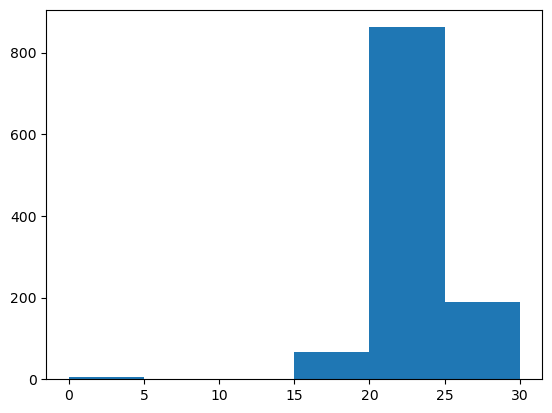

In [42]:
bins = np.arange(0, 35, 5)
plt.hist(flights[relative_diff_high_outliers & ET_less_30_min]['CRSElapsedTime'], bins = bins)
plt.show()

There are flights with sheduled duration less than 5 minutes (!!!) which actual elaplsed time was much highter (they are outliers)

In [43]:
# Filtering the flights with Elapsed time less than 15, which relative difference of ETs is high
flights[relative_diff_high_outliers & (flights['CRSElapsedTime'] < 15)][rout_info + ['ActualElapsedTime']]

,Flight_Number_Reporting_Airline,Origin,Dest,CRSDepDT,CRSElapsedTime,ActualElapsedTime
18294052,5035,FWA,ORD,2017-03-29 19:24:00,4.0,67.0
19335470,7410,DTW,CIU,2017-05-22 15:10:00,1.0,83.0
26019611,5132,SLN,HYS,2018-06-02 17:10:00,5.0,42.0
26634021,5903,MTJ,DFW,2018-07-10 12:27:00,1.0,182.0
26989871,4493,MSP,LGA,2018-07-04 07:09:00,1.0,174.0
27319025,5123,CLT,PGV,2018-08-19 22:25:00,1.0,66.0


And these flights seem very unsual due to extreemly short scheduled elapsed times. I plan to drop them

In [44]:
flights = flights[~(relative_diff_high_outliers & (flights['CRSElapsedTime'] < 15))]

We have to recalculate the boarders for outliers because we deleted some records above

In [45]:
outlier_limit_low, outlier_limit_high = get_outliers_range(flights['RelElapTimeDiff'])

# Filtering flights that had actual elapsed time to short relative to scheduled 
relative_diff_low_outliers = (flights['RelElapTimeDiff'] < outlier_limit_low) 
relative_diff_high_outliers = (flights['RelElapTimeDiff'] > outlier_limit_high)
outliers = (flights['RelElapTimeDiff'] < outlier_limit_low) | (flights['RelElapTimeDiff'] > outlier_limit_high)

Outliers with scheduled duration of flight higher than 15 minutes

In [46]:
# Filtering the flights with Elapsed time between 15 and 20 minutes, which relative difference of ETs is high
pd.set_option('display.max_rows', 70)
pd.set_option('display.width', 120)
print(flights[relative_diff_high_outliers & (15 < flights['CRSElapsedTime']) & 
              (flights['CRSElapsedTime'] < 20)][rout_info + ['ActualElapsedTime']])
pd.reset_option('display.max_rows')
pd.reset_option('display.width')

          Flight_Number_Reporting_Airline Origin Dest            CRSDepDT  CRSElapsedTime  ActualElapsedTime
2435800                                65    WRG  PSG 2014-06-08 10:48:00            19.0               30.0
2437272                                65    WRG  PSG 2014-06-09 10:48:00            19.0               25.0
2437750                                65    WRG  PSG 2014-06-10 10:48:00            19.0               24.0
2438131                                65    WRG  PSG 2014-06-15 10:48:00            19.0               23.0
2443225                                65    WRG  PSG 2014-06-14 10:48:00            19.0               31.0
2935878                                65    WRG  PSG 2014-07-01 10:48:00            19.0               23.0
2939064                                65    WRG  PSG 2014-07-04 10:48:00            19.0               24.0
3004362                                65    WRG  PSG 2014-07-06 10:49:00            19.0               23.0
3100525            

These flights look like delayed normal short flights 

In [47]:
# Printing some summary for ALL OUTLIERS
print('In 2014-2018 there were {:,d} flights with relative ET difference out of range ({:.2%}, {:+.2%}%), which represent {:.2%} of total flights'
      .format(n:=len(flights[outliers]['Flight_Number_Reporting_Airline']), 
              outlier_limit_low, 
              outlier_limit_high, 
              n / len(flights)))

In 2014-2018 there were 1,389,038 flights with relative ET difference out of range (-25.23%, +16.66%%), which represent 4.61% of total flights


Some examples of lower ouliers

In [48]:
pd.set_option('display.width', 200)
# Printing the TOP-10 fasterst flights
print(flights[relative_diff_low_outliers][rout_info + ['ActualElapsedTime', 
                        'ElapsedTimeDiff',
                        'RelElapTimeDiff']]
     .sort_values('RelElapTimeDiff', ascending=True).head(10))
print('There are {:,d} flights which are low outliers'.format(len(flights[relative_diff_low_outliers])))
pd.reset_option('display.width')

          Flight_Number_Reporting_Airline Origin Dest            CRSDepDT  CRSElapsedTime  ActualElapsedTime  ElapsedTimeDiff  RelElapTimeDiff
21568647                             5028    SBP  SFO 2017-10-09 08:55:00           302.0               52.0           -250.0        -0.827637
27060967                             5132    SLN  HYS 2018-07-17 05:40:00           161.0               44.0           -117.0        -0.726562
10814398                              969    SAN  SFO 2015-11-03 20:15:00           285.0               84.0           -201.0        -0.705078
24184719                             4528    MKE  DTW 2018-03-29 05:27:00           253.0               76.0           -177.0        -0.699707
24791714                             4456    PSP  SLC 2018-04-26 06:07:00           290.0               93.0           -197.0        -0.679199
5769493                              5621    MCN  ATL 2014-12-10 21:00:00            60.0               21.0            -39.0        -0.649902

Some data looks very unusual: how is it possible that the flight (the first line in the exaple above) was scheduled with elapsed time of 302 minutes and airplane actually flew so fast that the total way from Origin to Destination took just 52 minutes? Let's use visualisation for analysis of this. 

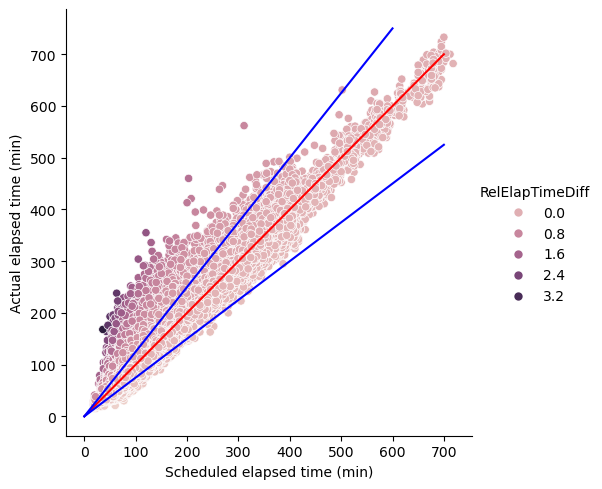

In [49]:
flights_sample = flights.sample(n=1000000)
sns.relplot(data=flights_sample,
            x='CRSElapsedTime', 
            y='ActualElapsedTime',
            hue='RelElapTimeDiff',
            kind='scatter')
plt.xlabel('Scheduled elapsed time (min)')
plt.ylabel('Actual elapsed time (min)')
line_x = [0, 700]
line_y = [0, 700]
line_up_x = [0, 600]
line_up_y = [0, 750]
line_down_x = [0, 700]
line_down_y = [0, 525]
plt.plot(line_x, line_y, color ='r')
plt.plot(line_up_x, line_up_y, color ='b')
plt.plot(line_down_x, line_down_y, color ='b')
plt.show()

On the graph above the red line represents the flights arrived just in time (their scheduled elapsed time equal their actual elapsed time). The blue lines represent +/-25% corridor. We can make some conclusions here:
1. The smaller the scheduled time the higher dispersion of actual elapsed times around sheduled time (red line).
2. It's worth to considere deleting these 'super fast' flights, because it is most like an error in schedule.
3. The distribution of differencies looks skewed to up (in terms of the graph represented above) and it sounds reasonable because to be delayed is more understandable for flights than to be too earlier due to technichal limitaions (airplanes have max speed). 

In [50]:
pd.set_option('display.width', 400)
print(flights[relative_diff_high_outliers][rout_info + ['ActualElapsedTime', 
                        'ElapsedTimeDiff',
                        'RelElapTimeDiff', 
                        'Diverted']].sort_values('RelElapTimeDiff', ascending = False).head(15))
print('There are {:,d} flights which are high outliers'.format(len(flights[relative_diff_high_outliers])))
pd.reset_option('display.width')

          Flight_Number_Reporting_Airline Origin Dest            CRSDepDT  CRSElapsedTime  ActualElapsedTime  ElapsedTimeDiff  RelElapTimeDiff  Diverted
17604178                             2615    JAX  FLL 2017-01-06 11:47:00            77.0              453.0            376.0         4.882812     False
22534193                             2066    AVL  ATL 2017-12-17 11:58:00            64.0              370.0            306.0         4.781250     False
13649647                             1492    AUS  IAH 2016-05-27 15:01:00            59.0              318.0            259.0         4.390625     False
16646892                             3998    ORD  FSD 2016-11-27 00:05:00           110.0              574.0            464.0         4.218750     False
22533210                             1177    RDU  ATL 2017-12-17 12:40:00            96.0              487.0            391.0         4.074219     False
22534171                             2048    BTR  ATL 2017-12-17 12:10:00         

In [51]:
print(flights[relative_diff_high_outliers].groupby(['Cancelled', 'Diverted'])['Flight_Number_Reporting_Airline'].agg('count'))

Cancelled  Diverted
False      False       1125392
Name: Flight_Number_Reporting_Airline, dtype: int64


We see that there are 1,125,392 flights which are high outliers and there are no diverted flights among them (which could explane their delay). These flights also seem unusual being scheduled (the top line in the table above for example) for 77 minutes and actually flew 453 minutes, given that Google shows 80 minutes duration for this flight.
I plan also delete some of these records but I am going to set less rigid criteria for delayed flights - +100% of scheduled elapsed time. 

In [52]:
relative_diff_low_outliers = (flights['RelElapTimeDiff'] < outlier_limit_low) 
relative_diff_high_outliers = (flights['RelElapTimeDiff'] > 1)
new_outliers = (flights['RelElapTimeDiff'] < outlier_limit_low) | (flights['RelElapTimeDiff'] > 1)

# Printing some summary for ALL OUTLIERS
print('In 2014-2018 there were {:,d} flights with relative ET difference out of range ({:.2%}, {:+.2%}%), which represent {:.2%} of total flights'
      .format(n:=len(flights[new_outliers]['Flight_Number_Reporting_Airline']), 
              outlier_limit_low, 
              1, 
              n / (t := len(flights))))
# Printing some summary for LOW OUTLIERS
print('        of which {:,d} flights are low outliers ({:.2%})'.format(l := len(flights[relative_diff_low_outliers]), l / t))
# Printing some summary for ALL OUTLIERS
print('        of which {:,d} flights are high outliers ({:.2%})'.format(h := len(flights[relative_diff_high_outliers]), h / t))


In 2014-2018 there were 277,967 flights with relative ET difference out of range (-25.23%, +100.00%%), which represent 0.92% of total flights
        of which 263,646 flights are low outliers (0.87%)
        of which 14,321 flights are high outliers (0.05%)


In [53]:
print('Number of records BEFORE deleting outliers: {:,d}'.format(b := len(flights)))
flights = flights[(~relative_diff_low_outliers) & (~relative_diff_high_outliers)]
print('Number of records AFTER deleting outliers: {:,d}'.format(a := len(flights)))
print('Number fo records deleted: {:,d}'.format(b - a))

Number of records BEFORE deleting outliers: 30,144,303
Number of records AFTER deleting outliers: 29,866,336
Number fo records deleted: 277,967


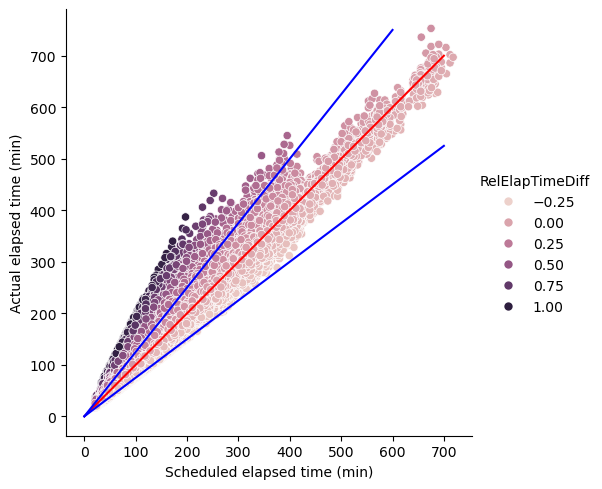

In [54]:
flights_sample = flights.sample(n=1000000)
sns.relplot(data=flights_sample,
            x='CRSElapsedTime', 
            y='ActualElapsedTime',
            hue='RelElapTimeDiff',
            kind='scatter')
plt.xlabel('Scheduled elapsed time (min)')
plt.ylabel('Actual elapsed time (min)')
line_x = [0, 700]
line_y = [0, 700]
line_up_x = [0, 600]
line_up_y = [0, 750]
line_down_x = [0, 700]
line_down_y = [0, 525]
plt.plot(line_x, line_y, color ='r')
plt.plot(line_up_x, line_up_y, color ='b')
plt.plot(line_down_x, line_down_y, color ='b')
plt.show()

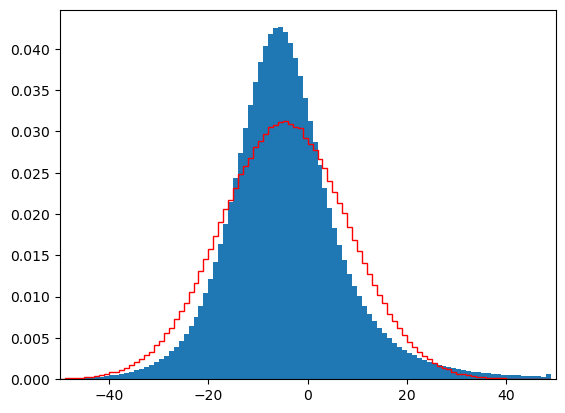

Mean difference between scheduled and actual time -4.62
Standard deviation of the difference 12.82


In [55]:
Act_vs_CRS_ET = flights['ElapsedTimeDiff']
Act_vs_CRS_ET = Act_vs_CRS_ET.astype(float)
sample_mean = Act_vs_CRS_ET.mean()
sample_std = Act_vs_CRS_ET.std()
rng = np.random.default_rng(18)
gauss_distr = rng.normal(sample_mean,
                        sample_std,
                        size=1000000)

bins = np.arange(-50,50)
plt.hist(Act_vs_CRS_ET, bins=bins, density=True)
plt.hist(gauss_distr, histtype='step', bins=bins, color='r', density=True)
plt.xlim(-50,50)
plt.show()
print('Mean difference between scheduled and actual time', round(sample_mean, 2))
print('Standard deviation of the difference', round(sample_std, 2))

The diffence between acheduled and actual elapsed time is not normally distribute (despite being very close), In average the actual elapsed time less than the scheduled (-4.62 min). However, this is the duration of the flight and not an arrival time.

It is interesting to examine the most negative values of the difference between scheduled and actual elapsed time: how shorter the actual duration of flight can be against its scheduled duration?

In [56]:
flights['ElapsedTimeDiff'].astype(float).describe()

count    2.931080e+07
mean    -4.619624e+00
std      1.281710e+01
min     -1.060000e+02
25%     -1.200000e+01
50%     -6.000000e+00
75%      1.000000e+00
max      2.520000e+02
Name: ElapsedTimeDiff, dtype: float64

Interesting!!!! Some flights lasted more than 100 minutes less/more than they were scheduled!!!

How many flights have an elapsed time difference that is an outlier in the range?
To answer this question let's analyse the relative difference of elapsed time, because on long distances the absolute difference in minutes can be higher.

In [57]:
print('Mean relative difference between scheduled and actual time (%)', round(flights['RelElapTimeDiff'].mean() * 100, 2))
print('Standard deviation of the relative difference (%)', round(flights['RelElapTimeDiff'].std() * 100, 2))

Mean relative difference between scheduled and actual time (%) -3.26
Standard deviation of the relative difference (%) 10.38


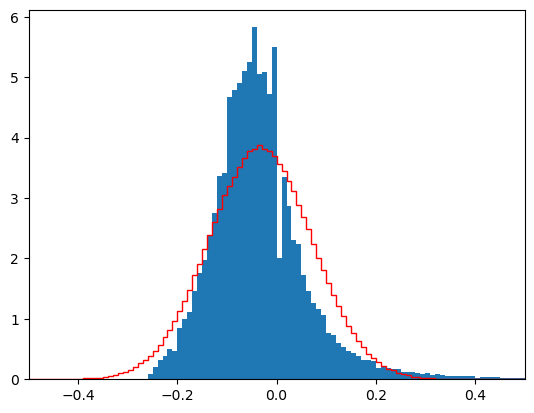

In [58]:
rng = np.random.default_rng(18)
gauss_distr = rng.normal(flights['RelElapTimeDiff'].mean(),
                        flights['RelElapTimeDiff'].std(),
                        size=1000000)

bins = np.arange(-1, 1, 0.01)

plt.hist(flights['RelElapTimeDiff'], bins=bins, density=True)
plt.hist(gauss_distr, histtype='step', bins=bins, color='r', density=True)
plt.xlim(-0.5, 0.5)
plt.show()

## Final data cleaning

I have created some temporary column which were needed to varify the dataset. Now when I have finished with data verifications, rectifeing and cleaning I can remove these temporary columns and some original columns that I left for verification purposes.

In [59]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29866336 entries, 0 to 30144614
Data columns (total 38 columns):
 #   Column                           Dtype                  
---  ------                           -----                  
 0   Reporting_Airline                category               
 1   Flight_Number_Reporting_Airline  int16                  
 2   Origin                           category               
 3   Dest                             category               
 4   DepDelay                         float16                
 5   DepartureDelayGroups             category               
 6   DepTimeBlk                       category               
 7   ArrDelay                         float16                
 8   ArrivalDelayGroups               category               
 9   ArrTimeBlk                       category               
 10  Cancelled                        bool                   
 11  CancellationCode                 category               
 12  Diverted         

In [60]:
flights = flights.drop(axis=1, columns=['diff_Act', 'diff_CRS', 'CRSElapsedTime', 'ActualElapsedTime', 'UTCElapsedTime_CRS',
                                 'UTCElapsedTime_Act', 'ElapsedTimeDiff', 'RelElapTimeDiff', 'ArrDelay','DepDelay'])

In [61]:
memory_usage_per_type(flights)
print(memory_usage(flights))

memory usage for number columns: 740.552 MB
memory usage for object columns: 227.862 MB
memory usage for datetimetz columns: 1139.310 MB
memory usage for category columns: 512.747 MB
memory usage for bool columns: 313.310 MB
2933.7812061309814


In [62]:
output_file_name = 'data/processed/processed_2014_2018_final.pickle'
with open(output_file_name, 'wb') as out_file:
    pickle.dump(flights, out_file, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
input_file_name = 'data/processed/processed_2014_2018_final.pickle'
with open(input_file_name, 'rb') as in_file:
    flights = pickle.load(in_file)

In [3]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29866336 entries, 0 to 30144614
Data columns (total 28 columns):
 #   Column                           Dtype                  
---  ------                           -----                  
 0   Reporting_Airline                category               
 1   Flight_Number_Reporting_Airline  int16                  
 2   Origin                           category               
 3   Dest                             category               
 4   DepartureDelayGroups             category               
 5   DepTimeBlk                       category               
 6   ArrivalDelayGroups               category               
 7   ArrTimeBlk                       category               
 8   Cancelled                        bool                   
 9   CancellationCode                 category               
 10  Diverted                         bool                   
 11  AirTime                          float16                
 12  CarrierDelay     

In [9]:
flights['ActArrDelay'] = (flights['ActArr_UTC'] - flights['CRSArr_UTC']).dt.total_seconds() / 60

In [10]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29866336 entries, 0 to 30144614
Data columns (total 29 columns):
 #   Column                           Dtype                  
---  ------                           -----                  
 0   Reporting_Airline                category               
 1   Flight_Number_Reporting_Airline  int16                  
 2   Origin                           category               
 3   Dest                             category               
 4   DepartureDelayGroups             category               
 5   DepTimeBlk                       category               
 6   ArrivalDelayGroups               category               
 7   ArrTimeBlk                       category               
 8   Cancelled                        bool                   
 9   CancellationCode                 category               
 10  Diverted                         bool                   
 11  AirTime                          float16                
 12  CarrierDelay     

In [11]:
flights['ActArrDelay'].describe()

count    2.937254e+07
mean     5.549851e+00
std      4.641660e+01
min     -1.302000e+03
25%     -1.300000e+01
50%     -5.000000e+00
75%      8.000000e+00
max      3.288000e+03
Name: ActArrDelay, dtype: float64

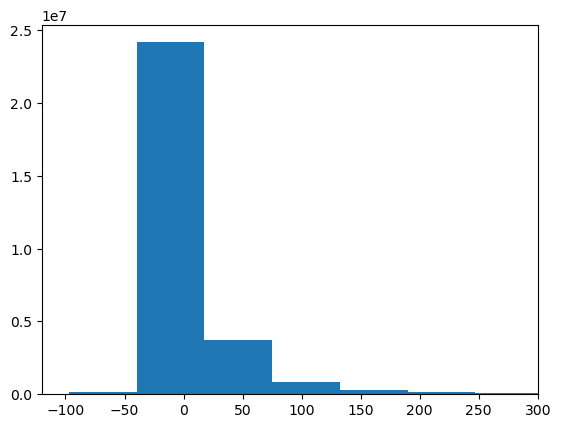

In [20]:
plt.hist(flights['ActArrDelay'], bins=80)
plt.xlim(-120, 300)
plt.show()

In [34]:
flights[flights['ActArrDelay'] < -90][['Flight_Number_Reporting_Airline', 'Origin',
                                       'CRSDepDT', 'CRSArrDT', 'DepDT', 'ArrDT', 
                                       'CRSDep_UTC', 'CRSArr_UTC', 'ActDep_UTC', 
                                       'ActArr_UTC', 'ActArrDelay']].sort_values(by = 'ActArrDelay')

,Flight_Number_Reporting_Airline,Origin,CRSDepDT,CRSArrDT,DepDT,ArrDT,CRSDep_UTC,CRSArr_UTC,ActDep_UTC,ActArr_UTC,ActArrDelay
19963957,201,HNL,2017-06-15 14:15:00,2017-06-15 17:55:00,2017-06-15 14:16:00,2017-06-15 20:13:00,2017-06-16 00:15:00+00:00,2017-06-16 07:55:00+00:00,2017-06-16 00:16:00+00:00,2017-06-15 10:13:00+00:00,-1302.0
16679557,50,HNL,2016-11-29 16:25:00,2016-11-30 06:55:00,2016-11-29 16:22:00,2016-11-29 15:29:00,2016-11-30 02:25:00+00:00,2016-11-30 11:55:00+00:00,2016-11-30 02:22:00+00:00,2016-11-29 20:29:00+00:00,-926.0
27148732,362,HNL,2018-08-10 15:00:00,2018-08-11 06:32:00,2018-08-10 14:57:00,2018-08-10 19:07:00,2018-08-11 01:00:00+00:00,2018-08-11 10:32:00+00:00,2018-08-11 00:57:00+00:00,2018-08-10 23:07:00+00:00,-685.0
20753988,12,SFO,2017-08-02 11:10:00,2017-08-02 20:08:00,2017-08-02 11:07:00,2017-08-02 10:19:00,2017-08-02 18:10:00+00:00,2017-08-03 00:08:00+00:00,2017-08-02 18:07:00+00:00,2017-08-02 14:19:00+00:00,-589.0
29924885,383,HNL,2018-12-02 21:20:00,2018-12-03 06:52:00,2018-12-02 21:19:00,2018-12-02 21:45:00,2018-12-03 07:20:00+00:00,2018-12-03 13:52:00+00:00,2018-12-03 07:19:00+00:00,2018-12-03 04:45:00+00:00,-547.0
...,...,...,...,...,...,...,...,...,...,...,...
16594403,425,JFK,2016-11-12 16:59:00,2016-11-12 20:43:00,2016-11-12 16:54:00,2016-11-12 19:11:00,2016-11-12 21:59:00+00:00,2016-11-13 04:43:00+00:00,2016-11-12 21:54:00+00:00,2016-11-13 03:11:00+00:00,-92.0
16348307,67,JFK,2016-11-10 16:30:00,2016-11-10 20:14:00,2016-11-10 16:26:00,2016-11-10 18:42:00,2016-11-10 21:30:00+00:00,2016-11-11 04:14:00+00:00,2016-11-10 21:26:00+00:00,2016-11-11 02:42:00+00:00,-92.0
29612063,5860,JAN,2018-12-26 14:08:00,2018-12-26 15:51:00,2018-12-26 14:42:00,2018-12-26 14:19:00,2018-12-26 20:08:00+00:00,2018-12-26 21:51:00+00:00,2018-12-26 20:42:00+00:00,2018-12-26 20:19:00+00:00,-92.0
14911738,5468,MOB,2016-07-29 14:55:00,2016-07-29 17:19:00,2016-07-29 13:24:00,2016-07-29 15:48:00,2016-07-29 19:55:00+00:00,2016-07-29 21:19:00+00:00,2016-07-29 18:24:00+00:00,2016-07-29 19:48:00+00:00,-91.0


## Conclusions

1. 

In [30]:
input_file_name = 'data/processed/processed_2017_6.pickle'
with open(input_file_name, 'rb') as in_file:
    fl2017_6 = pickle.load(in_file)

In [31]:
fl2017_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494266 entries, 0 to 494265
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype                  
---  ------                           --------------   -----                  
 0   Reporting_Airline                494266 non-null  category               
 1   Flight_Number_Reporting_Airline  494266 non-null  int16                  
 2   Origin                           494266 non-null  category               
 3   Dest                             494266 non-null  category               
 4   DepDelay                         489170 non-null  float16                
 5   DepartureDelayGroups             489170 non-null  category               
 6   DepTimeBlk                       494266 non-null  category               
 7   ArrDelay                         487581 non-null  float16                
 8   ArrivalDelayGroups               487581 non-null  category               
 9   ArrTimeBlk     

In [35]:
fl2017_6[(fl2017_6['Flight_Number_Reporting_Airline'] == 201) & (fl2017_6['Origin'] == 'HNL')]


,Reporting_Airline,Flight_Number_Reporting_Airline,Origin,Dest,DepDelay,DepartureDelayGroups,DepTimeBlk,ArrDelay,ArrivalDelayGroups,ArrTimeBlk,...,DepDT,ArrDT,CRSDep_UTC,CRSArr_UTC,ActDep_UTC,ActArr_UTC,UTCElapsedTime_CRS,UTCElapsedTime_Act,diff_CRS,diff_Act
109440,UA,201,HNL,GUM,5.0,0,1400-1459,0.0,0,1700-1759,...,2017-06-30 14:20:00,2017-06-30 17:55:00,2017-07-01 00:15:00+00:00,2017-06-30 07:55:00+00:00,2017-07-01 00:20:00+00:00,2017-06-30 07:55:00+00:00,-980.0,-985.0,-1440.0,-1440.0
111276,UA,201,HNL,GUM,-4.0,-1,1400-1459,-5.0,-1,1700-1759,...,2017-06-29 14:11:00,2017-06-29 17:50:00,2017-06-30 00:15:00+00:00,2017-06-29 07:55:00+00:00,2017-06-30 00:11:00+00:00,2017-06-29 07:50:00+00:00,-980.0,-981.0,-1440.0,-1440.0
113116,UA,201,HNL,GUM,4.0,0,1400-1459,-5.0,-1,1700-1759,...,2017-06-28 14:19:00,2017-06-28 17:50:00,2017-06-29 00:15:00+00:00,2017-06-28 07:55:00+00:00,2017-06-29 00:19:00+00:00,2017-06-28 07:50:00+00:00,-980.0,-989.0,-1440.0,-1440.0
114952,UA,201,HNL,GUM,-2.0,-1,1400-1459,-8.0,-1,1700-1759,...,2017-06-27 14:13:00,2017-06-27 17:47:00,2017-06-28 00:15:00+00:00,2017-06-27 07:55:00+00:00,2017-06-28 00:13:00+00:00,2017-06-27 07:47:00+00:00,-980.0,-986.0,-1440.0,-1440.0
117466,UA,201,HNL,GUM,43.0,2,1400-1459,16.0,1,1700-1759,...,2017-06-14 14:58:00,2017-06-14 18:11:00,2017-06-15 00:15:00+00:00,2017-06-14 07:55:00+00:00,2017-06-15 00:58:00+00:00,2017-06-14 08:11:00+00:00,-980.0,-1007.0,-1440.0,-1440.0
119297,UA,201,HNL,GUM,-1.0,-1,1400-1459,-25.0,-2,1700-1759,...,2017-06-13 14:14:00,2017-06-13 17:30:00,2017-06-14 00:15:00+00:00,2017-06-13 07:55:00+00:00,2017-06-14 00:14:00+00:00,2017-06-13 07:30:00+00:00,-980.0,-1004.0,-1440.0,-1440.0
121128,UA,201,HNL,GUM,3.0,0,1400-1459,-26.0,-2,1700-1759,...,2017-06-12 14:18:00,2017-06-12 17:29:00,2017-06-13 00:15:00+00:00,2017-06-12 07:55:00+00:00,2017-06-13 00:18:00+00:00,2017-06-12 07:29:00+00:00,-980.0,-1009.0,-1440.0,-1440.0
122963,UA,201,HNL,GUM,-4.0,-1,1400-1459,-24.0,-2,1700-1759,...,2017-06-11 14:11:00,2017-06-11 17:31:00,2017-06-12 00:15:00+00:00,2017-06-11 07:55:00+00:00,2017-06-12 00:11:00+00:00,2017-06-11 07:31:00+00:00,-980.0,-1000.0,-1440.0,-1440.0
370698,UA,201,HNL,GUM,-1.0,-1,1400-1459,-10.0,-1,1700-1759,...,2017-06-26 14:14:00,2017-06-26 17:45:00,2017-06-27 00:15:00+00:00,2017-06-26 07:55:00+00:00,2017-06-27 00:14:00+00:00,2017-06-26 07:45:00+00:00,-980.0,-989.0,-1440.0,-1440.0
372534,UA,201,HNL,GUM,-2.0,-1,1400-1459,-25.0,-2,1700-1759,...,2017-06-25 14:13:00,2017-06-25 17:30:00,2017-06-26 00:15:00+00:00,2017-06-25 07:55:00+00:00,2017-06-26 00:13:00+00:00,2017-06-25 07:30:00+00:00,-980.0,-1003.0,-1440.0,-1440.0


In [38]:
source_zip_file = 'data/interim/csv_flight.zip'
data_file = 'csv_flight/report_2017_6.csv'
csv2017_6 = load_data_from(source_zip_file, data_file)

In [39]:
csv2017_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494266 entries, 0 to 494265
Columns: 110 entries, Year to Unnamed: 109
dtypes: bool(3), datetime64[ns](1), float64(67), int64(21), object(18)
memory usage: 404.9+ MB


In [44]:
pd.set_option('display.max_rows', 200)
csv2017_6[(csv2017_6['Flight_Number_Reporting_Airline'] == 201) 
          & (csv2017_6['Origin'] == 'HNL')
          & (csv2017_6['DayofMonth'] == 15)].T 

,403466
Year,2017
Quarter,2
Month,6
DayofMonth,15
DayOfWeek,4
FlightDate,2017-06-15 00:00:00
Reporting_Airline,UA
DOT_ID_Reporting_Airline,19977
IATA_CODE_Reporting_Airline,UA
Tail_Number,N212UA
